# Term Project (MENG 35500) - Rebecca D'Antonio

## Parallel Tempering Monte Carlo

In [123]:
#imports
import os
import math
import time
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from IPython import display
from itertools import cycle

In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [4]:
# fix random seed for reproducibility
np.random.seed(17896)

In [1399]:
#randomly position the particle within the 1-D potential
def init_rand(L):
    
    pos = np.random.random(1)*L
       
    return pos

In [1398]:
#assign velocity of the particle as a random draw from the Maxwell-Boltzmann
#distribution at temperature T
def vMaxBoltz(T):
    
    #unitless
    kB = 1 
    
    stdev = np.sqrt(kB*T)
    vel = np.random.normal(0.,stdev)
        
    return vel

In [1468]:
#compute the potential energy of the particle
def E_pot(x, sigma):
    
    s2 = sigma**2
    e0 = 2.
    e1 = 1.
    e2 = 1.
    
    E1 = 20*np.exp(-20*x**2/s2)
    E2 = -e0*np.exp(-e0*(x-0.5)**2/s2)
    E3 = e1*np.exp(-e1*(x-1.)**2/s2)
    E4 = -e2*np.exp(-e2*(x-1.5)**2/s2)
    E5 = 20*np.exp(-20*(x-2.)**2/s2)
    
    Epot = E1 + E2 + E3 + E4 + E5

    return Epot

In [1402]:
#compute the kinetic energy of the particle
def E_kin(vel):
    
    Ekin = 0.5*vel**2
    
    return Ekin

In [1467]:
#define the force on the particle as the negative gradient of the potential
def force(x, sigma):
    
    s2 = sigma**2
    e0 = 2.
    e1 = 1.
    e2 = 1.
    
    f1 = 800*x/s2*np.exp(-20*x**2/s2)
    f2 = -2*e0**2*(x-0.5)/s2*np.exp(-e0*(x-0.5)**2/s2)
    f3 = 2*e1**2*(x-1.)/s2*np.exp(-e1*(x-1.)**2/s2)
    f4 = -2*e2**2*(x-1.5)/s2*np.exp(-e2*(x-1.5)**2/s2)
    f5 = 800*(x-2.)/s2*np.exp(-20*(x-2.)**2/s2)
    
    f = f1 + f2 + f3 + f4 + f5
    
    return f

In [1543]:
#langevin dynamics update step
def langevin(x, vel, sigma, dt, T):
    
    gamma = 15
    kB = 1
    kBT = kB*T

    f = force(x,sigma)

    vel = vel + f*dt/2.
    
    test = x + vel*dt/2.
    
    if test < 2 and test > 0:
        x = test

    R = np.random.normal()
    c1 = np.exp(-gamma*dt)
    c2 = np.sqrt(1-c1*c1)*np.sqrt(kBT)
        
    vel = c1*vel + R*c2

    test = x + vel*dt/2.
    
    if test < 2 and test > 0:
        x = test
        
    f = force(x, sigma)

    vel = vel + f*dt/2.
        
    return x, vel

In [1567]:
#Molecular Dynamics Main Loop
def MC_PT(T, N, dt, nSteps, printModulus, MC_Modulus, sigma, swap):
    
    #unitless
    m = 1
    kB = 1
    
    #temperature initializations
    Temp = np.zeros(N)
    for i in range(N):
        Temp[i] = T
        T+=10
  
    #energies
    EPot = np.zeros(N)
    EKin = np.zeros(N)
    ETot = np.zeros(N) 

    #positions and velocities
    pos = np.zeros(N)
    vel = np.zeros(N)
    
    #MC swap acceptance ratios
    num_swap_trials = np.zeros(N-1)
    num_swap_accept = np.zeros(N-1)
    
    #random configuration per replica
    for count in range(N):
        T = Temp[count]
        pos[count] = init_rand(2)
        vel[count] = vMaxBoltz(T)
    
    #for plotting
    EPot_list = np.zeros((N,nSteps))
    EKin_list = np.zeros((N,nSteps))
    ETot_list = np.zeros((N,nSteps))
    Temp_list = np.zeros((N,nSteps))
    Pos_list = np.zeros((N,nSteps))
    Vel_list = np.zeros((N,nSteps))
    t_list = np.zeros(nSteps)
    
    for step in range(0, nSteps):
        
        for count in range(N):
            
            #MD step
            pos[count], vel[count] = langevin(pos[count], vel[count], sigma, dt, Temp[count])

            #calculations
            EPot[count] = E_pot(pos[count], sigma)
            EKin[count] = E_kin(vel[count])
            ETot[count] = EPot[count]+EKin[count]
           
            #add data values 
            EPot_list[count,step] = EPot[count]
            EKin_list[count,step] = EKin[count]
            ETot_list[count,step] = ETot[count]
            Temp_list[count,step] = Temp[count]
            Pos_list[count, step] = pos[count]
            Vel_list[count, step] = vel[count]
            t_list[step] = (step+1)*dt
                  
        #attempt a swap every MC_Modulus if swaps are turned on
        if (step % MC_Modulus == 0 and swap):
            
            cycler = cycle((True, False))
            
            for k in range(N):
                
                if k > 0:
                    
                    if next(cycler):
                        #swap (0,1), (2,3), ...
                        partners = [(j-1, j) for j in range(1, N, 2)]
                    else:
                        #swap (1,2), (3,4), ...
                        partners = [(j-1, j) for j in range(2, N, 2)]
                        
                    #for each pair of replicas, attempt an exchange
                    for (i,j) in partners:
                        
                        Ti, Tj = Temp[i], Temp[j]
                        Ei, Ej = ETot[i], ETot[j]
                        
                        #PT acceptance criteria
                        chi = (Ei - Ej)*( (1/kB*Ti) - (1/kB*Tj) )
                        
                        #if accept, swap temperatures
                        if np.random.random() < np.exp(chi):
                            
                            temp = Temp[i]
                            Temp[i] = Temp[j]
                            Temp[j] = temp
                            
                            Temp_list[i,step] = Temp[i]
                            Temp_list[j,step] = Temp[j]
                            
                            num_swap_accept[i] += 1
                            
                        num_swap_trials[i] += 1                      
        
        #print every printModulus steps
        if(step % printModulus == 0):
            for i in range(N):
                print("T%s: Kinetic Energy: %.3f, Potential Energy: %.3f, Total Energy: %.3f, Temperature: %.3f, Position: %.3f" % (i+1, EKin[i],EPot[i],ETot[i],Temp[i],pos[i]))
            if (swap):
                for i in range(N-1):
                        print("Swap Acceptance Ratio (Pair %s): %.3f" % (i+1, num_swap_accept[i]/num_swap_trials[i]))
            print("")
     
    #plots
    for i in range(N):
        TPlot = Temp_list[i]
        plt.plot(t_list, TPlot, label='T%s' % (i+1))
    plt.ylabel('Temperature')
    plt.xlabel('Time')
    plt.legend()
    plt.show()  
    
    for i in range(N):
        EPotPlot = EPot_list[i]
        plt.plot(t_list, EPotPlot, label='T%s' % (i+1))
    plt.ylabel('Potential Energy')
    plt.xlabel('Time')
    plt.legend()
    plt.show()
    
    for i in range(N):
        EKinPlot = EKin_list[i]
        plt.plot(t_list, EKinPlot, label='T%s' % (i+1))
    plt.ylabel('Kinetic Energy')
    plt.xlabel('Time')
    plt.legend()
    plt.show()
    
    for i in range(N):
        PosPlot = Pos_list[i]
        plt.plot(t_list, PosPlot, label='T%s' % (i+1), color = 'c')
        plt.ylabel('Particle Position')
        plt.xlabel('Time')
        plt.legend()
        plt.show()
        
    for i in range(N):
        PosPlot = Pos_list[i]
        plt.plot(t_list, PosPlot, label='T%s' % (i+1))
    plt.ylabel('Particle Position')
    plt.xlabel('Time')
    plt.legend()
    plt.show()
    
    #histograms
    def bin_centers(bin_edges):
        return (bin_edges[1:]+bin_edges[:-1])/2.
    
    for i in range(N):

        plt.figure()
        dist_hist, dist_bin_edges = np.histogram(Pos_list[i],bins=25,density=True)
        vel_hist, vel_bin_edges = np.histogram(Vel_list[i],bins=25,density=True)

        plt.plot(bin_centers(dist_bin_edges), dist_hist,marker='o',label='P(x)',linestyle='')
        plt.plot(bin_centers(vel_bin_edges), vel_hist,marker='s',label='P(v)',linestyle='')
        plt.legend()
        plt.title("REPLICA %s" % (i+1))

#### Choose how many replicas you want to run and whether you want to allow swapping:

In [1577]:
N = int(input("Number of Replicas (1-15): "))
swap = int(input("Swapping On (1) Swapping Off (0): "))

Number of Replicas (1-15): 7
Swapping On (1) Swapping Off (0): 1


#### Run your simulation:

T1 = 30, $\sigma$ = 0.3, dt = 0.05, nSteps = 10000, printModulus = 100, swapModulus = 100

In [ ]:
MC_PT(30, n, 0.05, 10000, 100, 100, 0.3, swap)

### Example Results:

10 Replicas, No Swapping

T1: Kinetic Energy: 0.474, Potential Energy: 0.785, Total Energy: 1.260, Temperature: 30.000, Position: 1.081
T2: Kinetic Energy: 0.173, Potential Energy: -0.367, Total Energy: -0.194, Temperature: 40.000, Position: 1.799
T3: Kinetic Energy: 3.474, Potential Energy: 0.761, Total Energy: 4.235, Temperature: 50.000, Position: 1.089
T4: Kinetic Energy: 15.494, Potential Energy: -1.889, Total Energy: 13.606, Temperature: 60.000, Position: 0.459
T5: Kinetic Energy: 4.233, Potential Energy: 0.253, Total Energy: 4.486, Temperature: 70.000, Position: 1.204
T6: Kinetic Energy: 48.944, Potential Energy: 0.441, Total Energy: 49.385, Temperature: 80.000, Position: 1.167
T7: Kinetic Energy: 9.314, Potential Energy: 19.921, Total Energy: 29.235, Temperature: 90.000, Position: 1.998
T8: Kinetic Energy: 1.251, Potential Energy: 0.847, Total Energy: 2.097, Temperature: 100.000, Position: 0.911
T9: Kinetic Energy: 0.006, Potential Energy: 0.921, Total Energy: 0.927, Temperature: 110.000, Position: 1.012

T1: Kinetic Energy: 0.373, Potential Energy: -1.712, Total Energy: -1.339, Temperature: 30.000, Position: 0.563
T2: Kinetic Energy: 0.202, Potential Energy: -0.434, Total Energy: -0.232, Temperature: 40.000, Position: 1.331
T3: Kinetic Energy: 0.039, Potential Energy: -1.207, Total Energy: -1.168, Temperature: 50.000, Position: 0.625
T4: Kinetic Energy: 0.660, Potential Energy: -1.091, Total Energy: -0.431, Temperature: 60.000, Position: 0.637
T5: Kinetic Energy: 0.148, Potential Energy: -0.123, Total Energy: 0.025, Temperature: 70.000, Position: 1.272
T6: Kinetic Energy: 0.052, Potential Energy: -1.934, Total Energy: -1.883, Temperature: 80.000, Position: 0.504
T7: Kinetic Energy: 0.009, Potential Energy: -0.656, Total Energy: -0.647, Temperature: 90.000, Position: 1.381
T8: Kinetic Energy: 0.000, Potential Energy: -0.929, Total Energy: -0.929, Temperature: 100.000, Position: 1.490
T9: Kinetic Energy: 0.092, Potential Energy: -1.928, Total Energy: -1.836, Temperature: 110.000, Positio

T1: Kinetic Energy: 1.268, Potential Energy: -1.755, Total Energy: -0.487, Temperature: 30.000, Position: 0.428
T2: Kinetic Energy: 0.482, Potential Energy: -0.484, Total Energy: -0.001, Temperature: 40.000, Position: 1.755
T3: Kinetic Energy: 0.079, Potential Energy: -1.810, Total Energy: -1.731, Temperature: 50.000, Position: 0.439
T4: Kinetic Energy: 0.041, Potential Energy: -1.532, Total Energy: -1.492, Temperature: 60.000, Position: 0.393
T5: Kinetic Energy: 0.386, Potential Energy: -1.910, Total Energy: -1.524, Temperature: 70.000, Position: 0.518
T6: Kinetic Energy: 0.134, Potential Energy: 0.164, Total Energy: 0.299, Temperature: 80.000, Position: 1.220
T7: Kinetic Energy: 0.502, Potential Energy: -1.331, Total Energy: -0.829, Temperature: 90.000, Position: 0.611
T8: Kinetic Energy: 1.039, Potential Energy: -1.768, Total Energy: -0.729, Temperature: 100.000, Position: 0.553
T9: Kinetic Energy: 0.859, Potential Energy: -0.928, Total Energy: -0.069, Temperature: 110.000, Position

T1: Kinetic Energy: 0.283, Potential Energy: -1.750, Total Energy: -1.468, Temperature: 30.000, Position: 0.557
T2: Kinetic Energy: 0.161, Potential Energy: -1.685, Total Energy: -1.525, Temperature: 40.000, Position: 0.567
T3: Kinetic Energy: 0.463, Potential Energy: -0.825, Total Energy: -0.363, Temperature: 50.000, Position: 1.626
T4: Kinetic Energy: 0.045, Potential Energy: -1.256, Total Energy: -1.211, Temperature: 60.000, Position: 0.357
T5: Kinetic Energy: 0.449, Potential Energy: -0.739, Total Energy: -0.290, Temperature: 70.000, Position: 1.404
T6: Kinetic Energy: 0.013, Potential Energy: -1.632, Total Energy: -1.619, Temperature: 80.000, Position: 0.575
T7: Kinetic Energy: 0.862, Potential Energy: -0.902, Total Energy: -0.040, Temperature: 90.000, Position: 1.468
T8: Kinetic Energy: 0.646, Potential Energy: -0.930, Total Energy: -0.284, Temperature: 100.000, Position: 0.653
T9: Kinetic Energy: 0.149, Potential Energy: -0.903, Total Energy: -0.754, Temperature: 110.000, Positi

T1: Kinetic Energy: 0.135, Potential Energy: -1.845, Total Energy: -1.710, Temperature: 30.000, Position: 0.447
T2: Kinetic Energy: 0.031, Potential Energy: -1.921, Total Energy: -1.890, Temperature: 40.000, Position: 0.472
T3: Kinetic Energy: 0.466, Potential Energy: -0.984, Total Energy: -0.518, Temperature: 50.000, Position: 0.647
T4: Kinetic Energy: 0.101, Potential Energy: -1.850, Total Energy: -1.750, Temperature: 60.000, Position: 0.448
T5: Kinetic Energy: 0.470, Potential Energy: 0.800, Total Energy: 1.270, Temperature: 70.000, Position: 0.893
T6: Kinetic Energy: 0.686, Potential Energy: -0.478, Total Energy: 0.208, Temperature: 80.000, Position: 0.247
T7: Kinetic Energy: 0.258, Potential Energy: -0.935, Total Energy: -0.676, Temperature: 90.000, Position: 1.555
T8: Kinetic Energy: 1.794, Potential Energy: -0.016, Total Energy: 1.778, Temperature: 100.000, Position: 1.253
T9: Kinetic Energy: 0.002, Potential Energy: -1.839, Total Energy: -1.836, Temperature: 110.000, Position: 

T1: Kinetic Energy: 0.062, Potential Energy: -1.917, Total Energy: -1.855, Temperature: 30.000, Position: 0.470
T2: Kinetic Energy: 0.039, Potential Energy: -1.005, Total Energy: -0.966, Temperature: 40.000, Position: 0.325
T3: Kinetic Energy: 0.041, Potential Energy: -1.467, Total Energy: -1.426, Temperature: 50.000, Position: 0.596
T4: Kinetic Energy: 0.013, Potential Energy: -1.447, Total Energy: -1.433, Temperature: 60.000, Position: 0.381
T5: Kinetic Energy: 1.977, Potential Energy: -1.922, Total Energy: 0.056, Temperature: 70.000, Position: 0.512
T6: Kinetic Energy: 0.005, Potential Energy: -0.680, Total Energy: -0.675, Temperature: 80.000, Position: 1.387
T7: Kinetic Energy: 0.006, Potential Energy: -0.825, Total Energy: -0.818, Temperature: 90.000, Position: 1.626
T8: Kinetic Energy: 0.000, Potential Energy: -0.694, Total Energy: -0.693, Temperature: 100.000, Position: 1.679
T9: Kinetic Energy: 0.599, Potential Energy: -0.929, Total Energy: -0.330, Temperature: 110.000, Positio

T1: Kinetic Energy: 0.110, Potential Energy: -1.588, Total Energy: -1.478, Temperature: 30.000, Position: 0.401
T2: Kinetic Energy: 0.004, Potential Energy: -1.823, Total Energy: -1.819, Temperature: 40.000, Position: 0.543
T3: Kinetic Energy: 0.023, Potential Energy: -1.846, Total Energy: -1.823, Temperature: 50.000, Position: 0.447
T4: Kinetic Energy: 0.460, Potential Energy: -1.936, Total Energy: -1.476, Temperature: 60.000, Position: 0.483
T5: Kinetic Energy: 0.349, Potential Energy: -0.803, Total Energy: -0.454, Temperature: 70.000, Position: 1.424
T6: Kinetic Energy: 0.463, Potential Energy: -1.847, Total Energy: -1.385, Temperature: 80.000, Position: 0.447
T7: Kinetic Energy: 1.782, Potential Energy: -1.867, Total Energy: -0.085, Temperature: 90.000, Position: 0.453
T8: Kinetic Energy: 0.049, Potential Energy: -0.282, Total Energy: -0.233, Temperature: 100.000, Position: 1.302
T9: Kinetic Energy: 0.110, Potential Energy: -0.537, Total Energy: -0.427, Temperature: 110.000, Positi

T1: Kinetic Energy: 0.624, Potential Energy: -1.922, Total Energy: -1.298, Temperature: 30.000, Position: 0.512
T2: Kinetic Energy: 0.025, Potential Energy: -1.823, Total Energy: -1.798, Temperature: 40.000, Position: 0.543
T3: Kinetic Energy: 0.034, Potential Energy: -1.851, Total Energy: -1.817, Temperature: 50.000, Position: 0.448
T4: Kinetic Energy: 0.002, Potential Energy: -1.904, Total Energy: -1.901, Temperature: 60.000, Position: 0.521
T5: Kinetic Energy: 1.718, Potential Energy: 0.436, Total Energy: 2.154, Temperature: 70.000, Position: 1.168
T6: Kinetic Energy: 1.075, Potential Energy: -0.240, Total Energy: 0.835, Temperature: 80.000, Position: 1.294
T7: Kinetic Energy: 2.463, Potential Energy: -1.233, Total Energy: 1.230, Temperature: 90.000, Position: 0.354
T8: Kinetic Energy: 0.299, Potential Energy: -0.102, Total Energy: 0.197, Temperature: 100.000, Position: 1.268
T9: Kinetic Energy: 1.931, Potential Energy: -0.941, Total Energy: 0.990, Temperature: 110.000, Position: 1.

T1: Kinetic Energy: 0.327, Potential Energy: -1.936, Total Energy: -1.609, Temperature: 30.000, Position: 0.483
T2: Kinetic Energy: 0.587, Potential Energy: -1.938, Total Energy: -1.350, Temperature: 40.000, Position: 0.500
T3: Kinetic Energy: 0.006, Potential Energy: -0.574, Total Energy: -0.568, Temperature: 50.000, Position: 1.362
T4: Kinetic Energy: 1.428, Potential Energy: -1.758, Total Energy: -0.330, Temperature: 60.000, Position: 0.555
T5: Kinetic Energy: 0.464, Potential Energy: -1.936, Total Energy: -1.472, Temperature: 70.000, Position: 0.483
T6: Kinetic Energy: 0.045, Potential Energy: -1.933, Total Energy: -1.888, Temperature: 80.000, Position: 0.505
T7: Kinetic Energy: 0.337, Potential Energy: -0.898, Total Energy: -0.561, Temperature: 90.000, Position: 1.587
T8: Kinetic Energy: 1.643, Potential Energy: -1.896, Total Energy: -0.253, Temperature: 100.000, Position: 0.523
T9: Kinetic Energy: 0.028, Potential Energy: -0.881, Total Energy: -0.853, Temperature: 110.000, Positi

T1: Kinetic Energy: 0.221, Potential Energy: -1.918, Total Energy: -1.698, Temperature: 30.000, Position: 0.471
T2: Kinetic Energy: 0.249, Potential Energy: -1.939, Total Energy: -1.690, Temperature: 40.000, Position: 0.488
T3: Kinetic Energy: 0.003, Potential Energy: -1.937, Total Energy: -1.934, Temperature: 50.000, Position: 0.502
T4: Kinetic Energy: 1.993, Potential Energy: -1.324, Total Energy: 0.669, Temperature: 60.000, Position: 0.612
T5: Kinetic Energy: 0.147, Potential Energy: -1.527, Total Energy: -1.380, Temperature: 70.000, Position: 0.392
T6: Kinetic Energy: 0.008, Potential Energy: -1.939, Total Energy: -1.931, Temperature: 80.000, Position: 0.498
T7: Kinetic Energy: 1.685, Potential Energy: -0.730, Total Energy: 0.955, Temperature: 90.000, Position: 0.672
T8: Kinetic Energy: 0.726, Potential Energy: -0.458, Total Energy: 0.268, Temperature: 100.000, Position: 1.764
T9: Kinetic Energy: 2.647, Potential Energy: -0.544, Total Energy: 2.103, Temperature: 110.000, Position: 

T1: Kinetic Energy: 0.014, Potential Energy: -1.421, Total Energy: -1.406, Temperature: 30.000, Position: 0.378
T2: Kinetic Energy: 0.390, Potential Energy: -1.694, Total Energy: -1.304, Temperature: 40.000, Position: 0.417
T3: Kinetic Energy: 0.041, Potential Energy: -1.509, Total Energy: -1.468, Temperature: 50.000, Position: 0.390
T4: Kinetic Energy: 0.730, Potential Energy: -1.129, Total Energy: -0.399, Temperature: 60.000, Position: 0.633
T5: Kinetic Energy: 1.371, Potential Energy: -1.726, Total Energy: -0.355, Temperature: 70.000, Position: 0.423
T6: Kinetic Energy: 0.868, Potential Energy: -1.782, Total Energy: -0.914, Temperature: 80.000, Position: 0.433
T7: Kinetic Energy: 0.094, Potential Energy: -1.898, Total Energy: -1.804, Temperature: 90.000, Position: 0.523
T8: Kinetic Energy: 0.507, Potential Energy: -0.342, Total Energy: 0.164, Temperature: 100.000, Position: 0.712
T9: Kinetic Energy: 0.513, Potential Energy: -1.431, Total Energy: -0.918, Temperature: 110.000, Positio

T1: Kinetic Energy: 0.158, Potential Energy: -1.496, Total Energy: -1.339, Temperature: 30.000, Position: 0.592
T2: Kinetic Energy: 0.298, Potential Energy: -1.880, Total Energy: -1.582, Temperature: 40.000, Position: 0.456
T3: Kinetic Energy: 0.165, Potential Energy: -1.061, Total Energy: -0.896, Temperature: 50.000, Position: 0.332
T4: Kinetic Energy: 0.205, Potential Energy: 2.117, Total Energy: 2.321, Temperature: 60.000, Position: 1.901
T5: Kinetic Energy: 0.452, Potential Energy: -0.568, Total Energy: -0.116, Temperature: 70.000, Position: 0.262
T6: Kinetic Energy: 0.080, Potential Energy: -0.285, Total Energy: -0.205, Temperature: 80.000, Position: 1.825
T7: Kinetic Energy: 0.576, Potential Energy: 0.011, Total Energy: 0.586, Temperature: 90.000, Position: 1.248
T8: Kinetic Energy: 0.190, Potential Energy: -1.641, Total Energy: -1.450, Temperature: 100.000, Position: 0.574
T9: Kinetic Energy: 1.058, Potential Energy: -0.372, Total Energy: 0.687, Temperature: 110.000, Position: 1

T1: Kinetic Energy: 0.141, Potential Energy: -1.859, Total Energy: -1.718, Temperature: 30.000, Position: 0.451
T2: Kinetic Energy: 0.198, Potential Energy: -1.851, Total Energy: -1.654, Temperature: 40.000, Position: 0.536
T3: Kinetic Energy: 1.258, Potential Energy: -1.875, Total Energy: -0.617, Temperature: 50.000, Position: 0.455
T4: Kinetic Energy: 0.053, Potential Energy: -0.880, Total Energy: -0.827, Temperature: 60.000, Position: 1.598
T5: Kinetic Energy: 0.117, Potential Energy: -1.780, Total Energy: -1.663, Temperature: 70.000, Position: 0.433
T6: Kinetic Energy: 0.012, Potential Energy: -0.364, Total Energy: -0.352, Temperature: 80.000, Position: 0.223
T7: Kinetic Energy: 2.225, Potential Energy: -0.946, Total Energy: 1.279, Temperature: 90.000, Position: 1.530
T8: Kinetic Energy: 0.016, Potential Energy: 0.821, Total Energy: 0.837, Temperature: 100.000, Position: 1.069
T9: Kinetic Energy: 0.010, Potential Energy: 0.227, Total Energy: 0.237, Temperature: 110.000, Position: 1

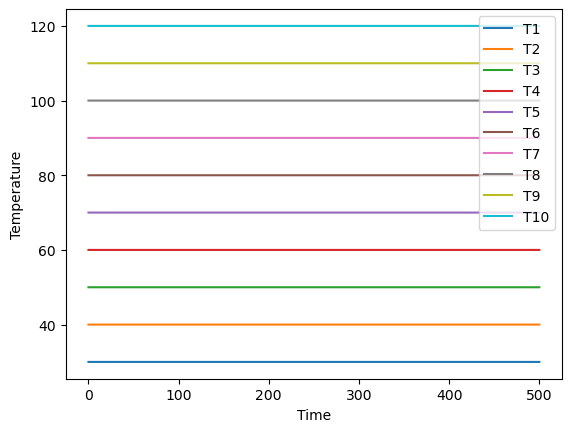

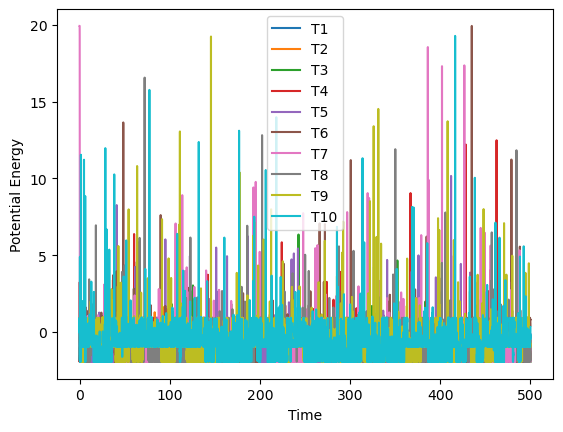

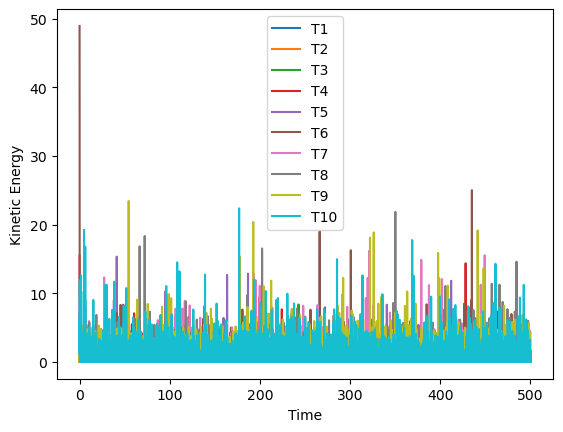

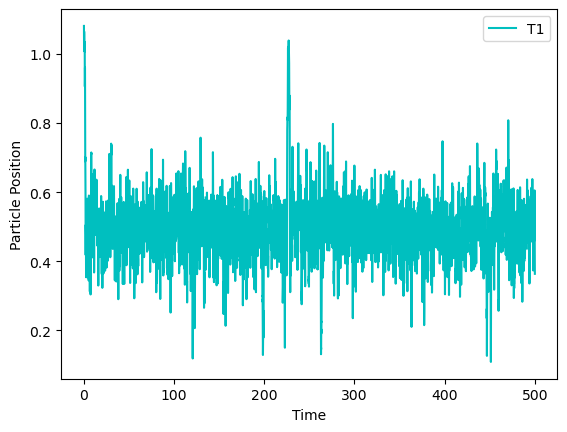

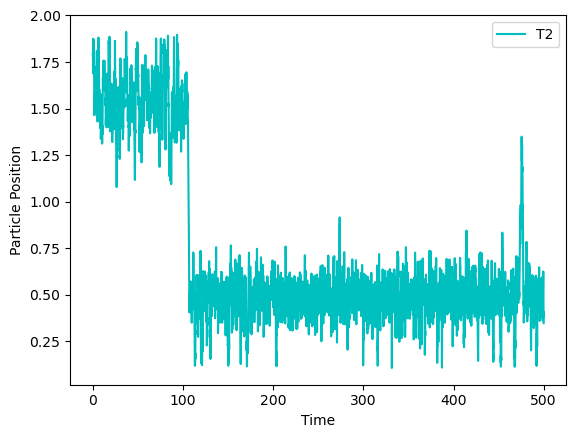

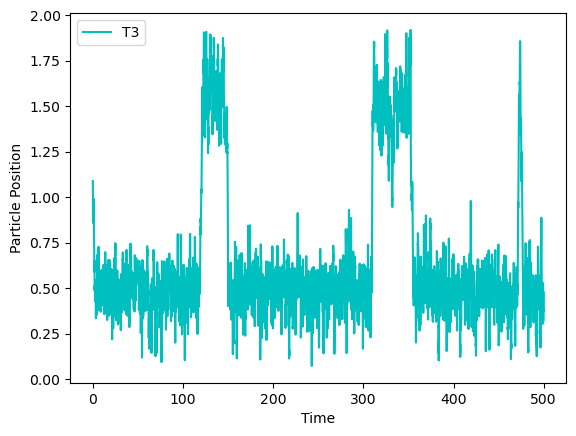

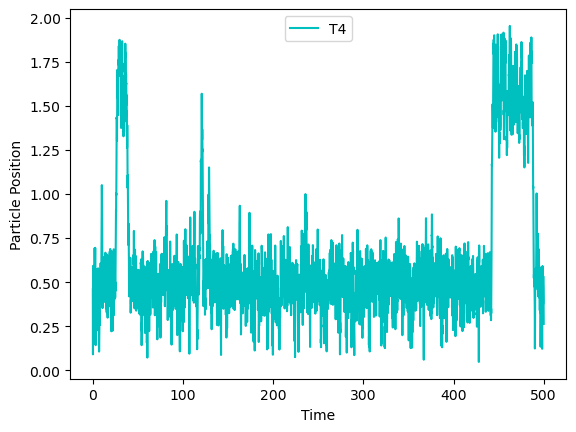

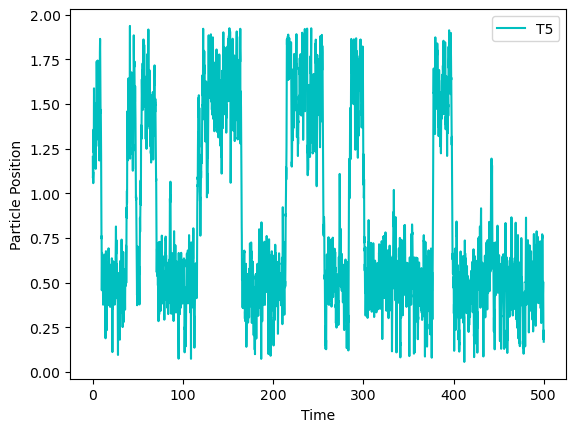

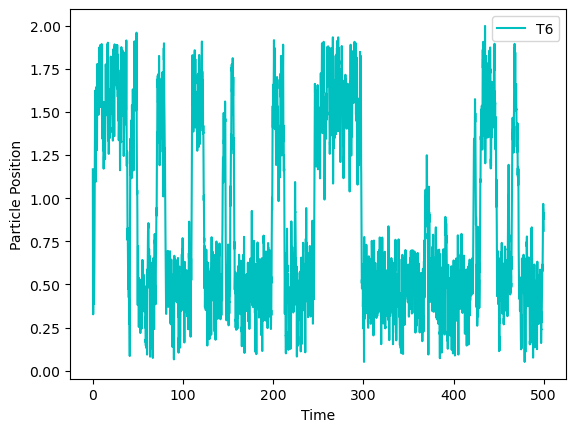

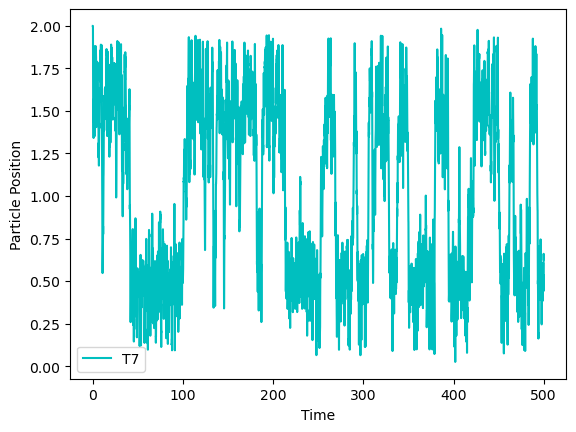

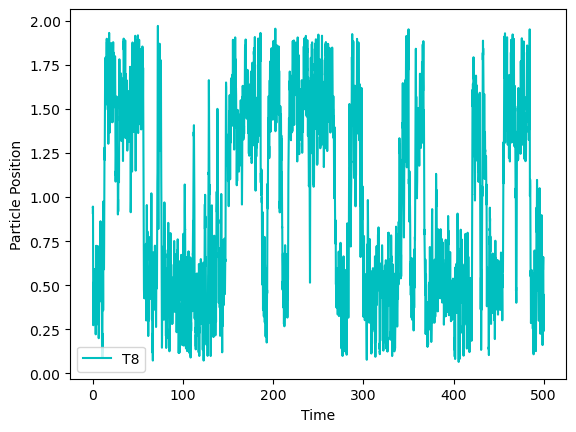

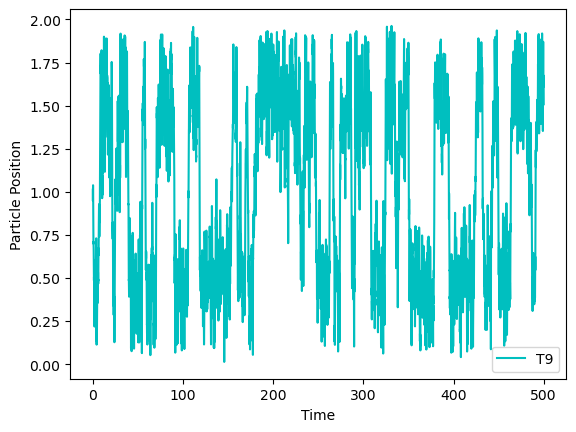

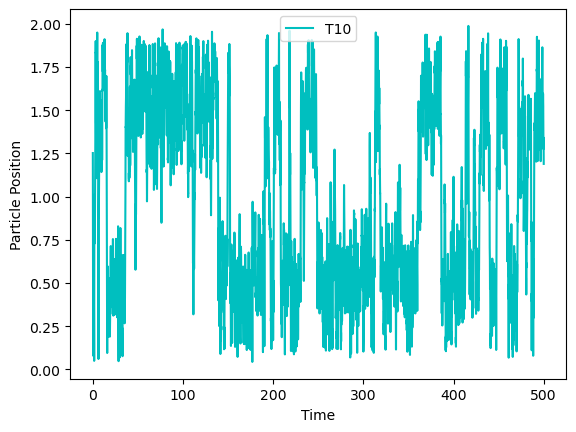

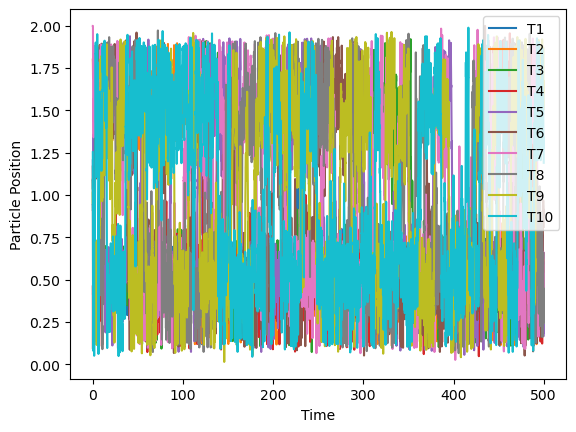

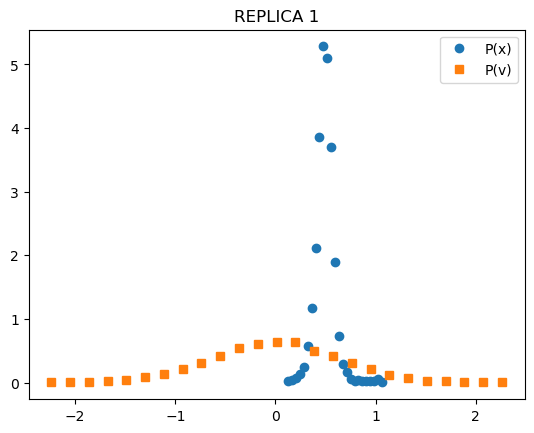

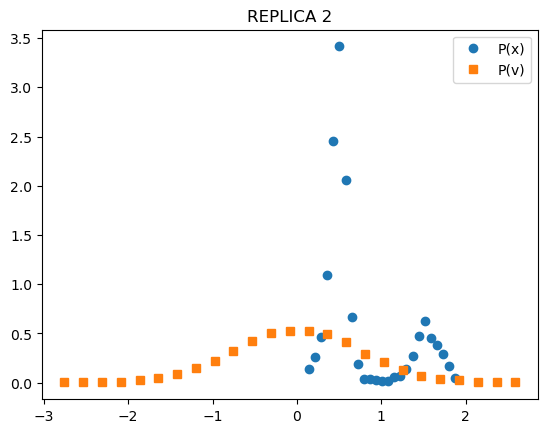

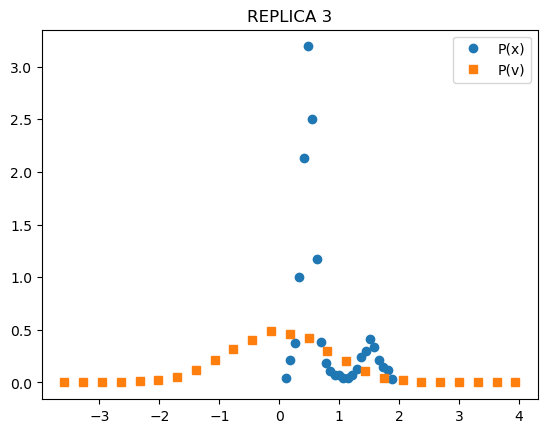

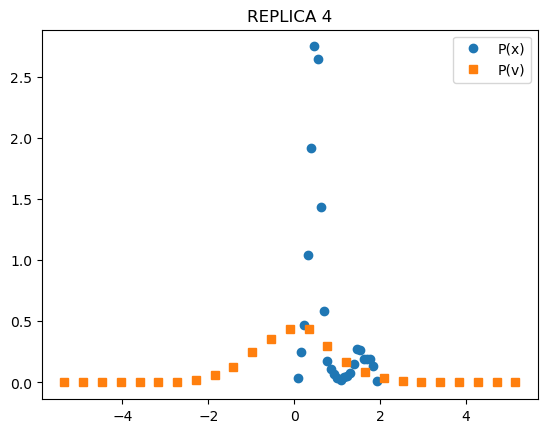

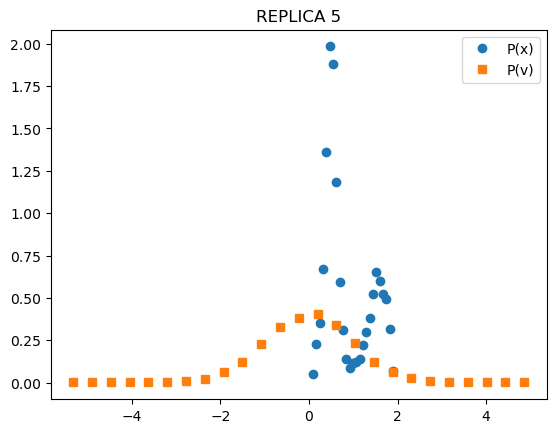

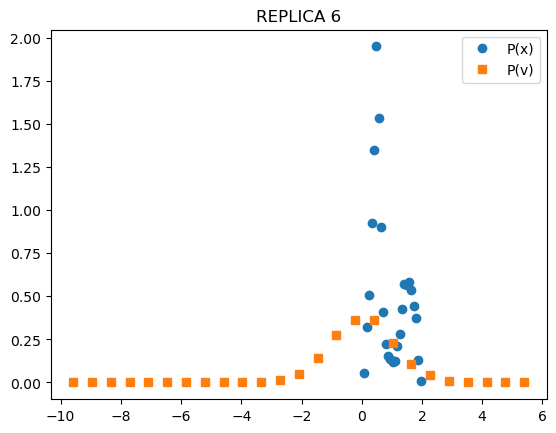

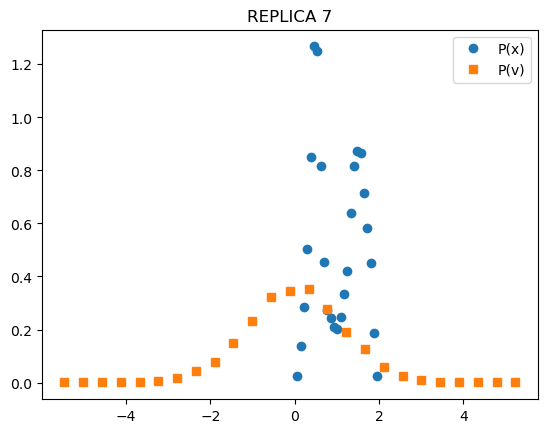

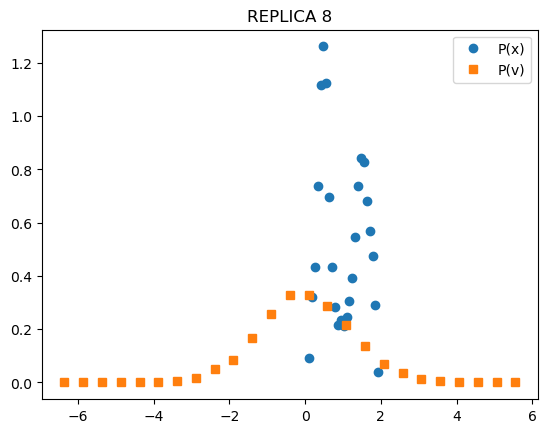

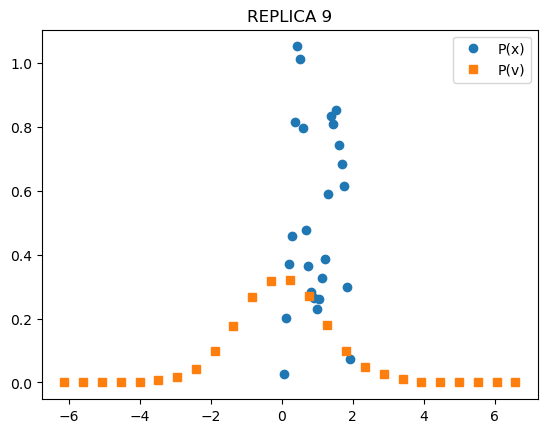

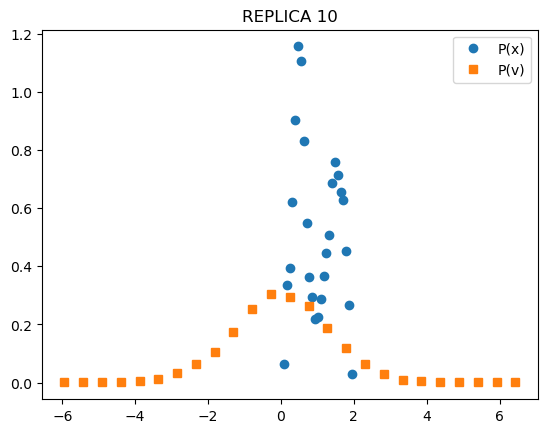

In [1564]:
MC_PT(30, 10, 0.05, 10000, 100, 100, 0.3, 0)

12 Replicas, With Swapping

T1: Kinetic Energy: 0.064, Potential Energy: -0.384, Total Energy: -0.320, Temperature: 40.000, Position: 0.707
T2: Kinetic Energy: 0.181, Potential Energy: 0.660, Total Energy: 0.841, Temperature: 30.000, Position: 1.118
T3: Kinetic Energy: 1.175, Potential Energy: -1.761, Total Energy: -0.586, Temperature: 100.000, Position: 0.429
T4: Kinetic Energy: 0.526, Potential Energy: -0.872, Total Energy: -0.347, Temperature: 90.000, Position: 0.307
T5: Kinetic Energy: 0.217, Potential Energy: -0.527, Total Energy: -0.310, Temperature: 80.000, Position: 1.739
T6: Kinetic Energy: 1.321, Potential Energy: -0.795, Total Energy: 0.526, Temperature: 70.000, Position: 1.640
T7: Kinetic Energy: 8.344, Potential Energy: -0.437, Total Energy: 7.907, Temperature: 60.000, Position: 1.772
T8: Kinetic Energy: 17.546, Potential Energy: -0.045, Total Energy: 17.501, Temperature: 50.000, Position: 1.856
T9: Kinetic Energy: 0.358, Potential Energy: 15.099, Total Energy: 15.458, Temperature: 110.000, Position:

T1: Kinetic Energy: 0.071, Potential Energy: -1.308, Total Energy: -1.236, Temperature: 100.000, Position: 0.363
T2: Kinetic Energy: 0.757, Potential Energy: -1.875, Total Energy: -1.118, Temperature: 40.000, Position: 0.530
T3: Kinetic Energy: 0.234, Potential Energy: -0.693, Total Energy: -0.458, Temperature: 30.000, Position: 1.680
T4: Kinetic Energy: 0.011, Potential Energy: -1.856, Total Energy: -1.845, Temperature: 90.000, Position: 0.535
T5: Kinetic Energy: 0.000, Potential Energy: -0.883, Total Energy: -0.883, Temperature: 60.000, Position: 1.458
T6: Kinetic Energy: 0.038, Potential Energy: -1.002, Total Energy: -0.965, Temperature: 120.000, Position: 0.645
T7: Kinetic Energy: 0.006, Potential Energy: -0.560, Total Energy: -0.555, Temperature: 80.000, Position: 1.727
T8: Kinetic Energy: 0.026, Potential Energy: 0.669, Total Energy: 0.695, Temperature: 50.000, Position: 0.857
T9: Kinetic Energy: 0.000, Potential Energy: 0.502, Total Energy: 0.502, Temperature: 110.000, Position:

T1: Kinetic Energy: 0.322, Potential Energy: -0.906, Total Energy: -0.584, Temperature: 40.000, Position: 1.471
T2: Kinetic Energy: 0.007, Potential Energy: -0.598, Total Energy: -0.590, Temperature: 100.000, Position: 1.367
T3: Kinetic Energy: 1.016, Potential Energy: 0.728, Total Energy: 1.744, Temperature: 30.000, Position: 0.872
T4: Kinetic Energy: 2.686, Potential Energy: -1.456, Total Energy: 1.229, Temperature: 120.000, Position: 0.382
T5: Kinetic Energy: 3.959, Potential Energy: -1.628, Total Energy: 2.331, Temperature: 50.000, Position: 0.407
T6: Kinetic Energy: 0.554, Potential Energy: -1.375, Total Energy: -0.821, Temperature: 140.000, Position: 0.372
T7: Kinetic Energy: 0.805, Potential Energy: -0.946, Total Energy: -0.141, Temperature: 60.000, Position: 1.526
T8: Kinetic Energy: 0.157, Potential Energy: -1.054, Total Energy: -0.897, Temperature: 90.000, Position: 0.331
T9: Kinetic Energy: 0.250, Potential Energy: -0.967, Total Energy: -0.717, Temperature: 70.000, Position:

C:\Users\rebec\anaconda3\envs\moleng37\lib\site-packages\ipykernel_launcher.py:89: RuntimeWarning: overflow encountered in exp


T1: Kinetic Energy: 0.465, Potential Energy: -0.615, Total Energy: -0.150, Temperature: 40.000, Position: 1.708
T2: Kinetic Energy: 1.175, Potential Energy: -1.579, Total Energy: -0.405, Temperature: 120.000, Position: 0.582
T3: Kinetic Energy: 0.316, Potential Energy: -0.556, Total Energy: -0.240, Temperature: 100.000, Position: 1.357
T4: Kinetic Energy: 0.920, Potential Energy: -0.397, Total Energy: 0.522, Temperature: 30.000, Position: 1.787
T5: Kinetic Energy: 0.066, Potential Energy: -1.316, Total Energy: -1.250, Temperature: 140.000, Position: 0.364
T6: Kinetic Energy: 0.550, Potential Energy: -0.920, Total Energy: -0.370, Temperature: 60.000, Position: 1.570
T7: Kinetic Energy: 0.008, Potential Energy: -0.861, Total Energy: -0.853, Temperature: 110.000, Position: 1.609
T8: Kinetic Energy: 0.061, Potential Energy: -0.465, Total Energy: -0.404, Temperature: 70.000, Position: 0.244
T9: Kinetic Energy: 0.093, Potential Energy: -0.488, Total Energy: -0.395, Temperature: 90.000, Posit

T1: Kinetic Energy: 1.267, Potential Energy: -1.291, Total Energy: -0.025, Temperature: 100.000, Position: 0.616
T2: Kinetic Energy: 0.677, Potential Energy: -0.901, Total Energy: -0.225, Temperature: 110.000, Position: 0.656
T3: Kinetic Energy: 0.104, Potential Energy: -1.851, Total Energy: -1.748, Temperature: 120.000, Position: 0.449
T4: Kinetic Energy: 0.065, Potential Energy: -0.336, Total Energy: -0.270, Temperature: 40.000, Position: 0.217
T5: Kinetic Energy: 11.348, Potential Energy: -0.905, Total Energy: 10.443, Temperature: 30.000, Position: 1.582
T6: Kinetic Energy: 0.542, Potential Energy: -0.407, Total Energy: 0.135, Temperature: 70.000, Position: 1.784
T7: Kinetic Energy: 0.741, Potential Energy: -0.178, Total Energy: 0.563, Temperature: 60.000, Position: 1.282
T8: Kinetic Energy: 0.022, Potential Energy: -1.764, Total Energy: -1.742, Temperature: 140.000, Position: 0.554
T9: Kinetic Energy: 0.006, Potential Energy: -1.280, Total Energy: -1.274, Temperature: 130.000, Posi

T1: Kinetic Energy: 1.252, Potential Energy: -0.910, Total Energy: 0.342, Temperature: 70.000, Position: 1.474
T2: Kinetic Energy: 0.758, Potential Energy: -0.918, Total Energy: -0.161, Temperature: 100.000, Position: 1.571
T3: Kinetic Energy: 2.386, Potential Energy: -1.881, Total Energy: 0.505, Temperature: 40.000, Position: 0.457
T4: Kinetic Energy: 0.106, Potential Energy: -0.937, Total Energy: -0.831, Temperature: 120.000, Position: 1.551
T5: Kinetic Energy: 1.240, Potential Energy: -0.909, Total Energy: 0.331, Temperature: 110.000, Position: 1.473
T6: Kinetic Energy: 2.174, Potential Energy: 0.630, Total Energy: 2.804, Temperature: 30.000, Position: 0.848
T7: Kinetic Energy: 0.015, Potential Energy: 0.242, Total Energy: 0.257, Temperature: 60.000, Position: 1.206
T8: Kinetic Energy: 0.954, Potential Energy: -1.864, Total Energy: -0.910, Temperature: 140.000, Position: 0.452
T9: Kinetic Energy: 0.449, Potential Energy: -0.933, Total Energy: -0.484, Temperature: 130.000, Position: 

T1: Kinetic Energy: 0.340, Potential Energy: -1.938, Total Energy: -1.597, Temperature: 100.000, Position: 0.485
T2: Kinetic Energy: 0.000, Potential Energy: -0.655, Total Energy: -0.655, Temperature: 70.000, Position: 1.693
T3: Kinetic Energy: 3.881, Potential Energy: 6.171, Total Energy: 10.052, Temperature: 30.000, Position: 1.928
T4: Kinetic Energy: 0.130, Potential Energy: -1.632, Total Energy: -1.503, Temperature: 140.000, Position: 0.407
T5: Kinetic Energy: 0.000, Potential Energy: -0.940, Total Energy: -0.940, Temperature: 120.000, Position: 1.547
T6: Kinetic Energy: 0.017, Potential Energy: -0.329, Total Energy: -0.312, Temperature: 50.000, Position: 0.215
T7: Kinetic Energy: 0.003, Potential Energy: 0.031, Total Energy: 0.034, Temperature: 40.000, Position: 0.754
T8: Kinetic Energy: 0.000, Potential Energy: -1.927, Total Energy: -1.926, Temperature: 130.000, Position: 0.510
T9: Kinetic Energy: 0.078, Potential Energy: -1.909, Total Energy: -1.831, Temperature: 110.000, Positi

T1: Kinetic Energy: 0.144, Potential Energy: -0.267, Total Energy: -0.124, Temperature: 70.000, Position: 1.299
T2: Kinetic Energy: 1.492, Potential Energy: -1.925, Total Energy: -0.434, Temperature: 100.000, Position: 0.510
T3: Kinetic Energy: 1.080, Potential Energy: -1.259, Total Energy: -0.179, Temperature: 40.000, Position: 0.619
T4: Kinetic Energy: 0.045, Potential Energy: -0.911, Total Energy: -0.866, Temperature: 130.000, Position: 1.475
T5: Kinetic Energy: 0.005, Potential Energy: -1.585, Total Energy: -1.580, Temperature: 140.000, Position: 0.581
T6: Kinetic Energy: 1.088, Potential Energy: -0.850, Total Energy: 0.238, Temperature: 30.000, Position: 1.614
T7: Kinetic Energy: 0.060, Potential Energy: -1.199, Total Energy: -1.139, Temperature: 110.000, Position: 0.349
T8: Kinetic Energy: 0.072, Potential Energy: -0.905, Total Energy: -0.833, Temperature: 120.000, Position: 1.470
T9: Kinetic Energy: 0.682, Potential Energy: 0.199, Total Energy: 0.882, Temperature: 80.000, Positi

T1: Kinetic Energy: 0.014, Potential Energy: -1.939, Total Energy: -1.925, Temperature: 120.000, Position: 0.497
T2: Kinetic Energy: 0.106, Potential Energy: -0.941, Total Energy: -0.835, Temperature: 70.000, Position: 1.505
T3: Kinetic Energy: 5.759, Potential Energy: -0.915, Total Energy: 4.844, Temperature: 30.000, Position: 1.574
T4: Kinetic Energy: 0.327, Potential Energy: 0.621, Total Energy: 0.948, Temperature: 40.000, Position: 1.127
T5: Kinetic Energy: 0.037, Potential Energy: -0.926, Total Energy: -0.889, Temperature: 90.000, Position: 1.487
T6: Kinetic Energy: 0.791, Potential Energy: -1.908, Total Energy: -1.118, Temperature: 130.000, Position: 0.519
T7: Kinetic Energy: 0.018, Potential Energy: -0.924, Total Energy: -0.906, Temperature: 100.000, Position: 1.485
T8: Kinetic Energy: 0.995, Potential Energy: -1.867, Total Energy: -0.872, Temperature: 80.000, Position: 0.453
T9: Kinetic Energy: 0.047, Potential Energy: -0.890, Total Energy: -0.843, Temperature: 60.000, Position

T1: Kinetic Energy: 0.413, Potential Energy: 1.844, Total Energy: 2.256, Temperature: 70.000, Position: 1.898
T2: Kinetic Energy: 0.032, Potential Energy: -0.661, Total Energy: -0.629, Temperature: 130.000, Position: 1.383
T3: Kinetic Energy: 0.678, Potential Energy: -0.829, Total Energy: -0.150, Temperature: 100.000, Position: 1.624
T4: Kinetic Energy: 0.703, Potential Energy: 0.915, Total Energy: 1.617, Temperature: 80.000, Position: 0.949
T5: Kinetic Energy: 0.003, Potential Energy: -0.287, Total Energy: -0.284, Temperature: 110.000, Position: 1.303
T6: Kinetic Energy: 0.006, Potential Energy: -1.547, Total Energy: -1.541, Temperature: 120.000, Position: 0.586
T7: Kinetic Energy: 0.113, Potential Energy: -0.909, Total Energy: -0.796, Temperature: 30.000, Position: 1.473
T8: Kinetic Energy: 0.005, Potential Energy: -1.610, Total Energy: -1.605, Temperature: 60.000, Position: 0.404
T9: Kinetic Energy: 1.275, Potential Energy: -0.420, Total Energy: 0.855, Temperature: 40.000, Position:

T1: Kinetic Energy: 1.458, Potential Energy: -0.825, Total Energy: 0.633, Temperature: 70.000, Position: 1.626
T2: Kinetic Energy: 0.395, Potential Energy: -1.460, Total Energy: -1.065, Temperature: 130.000, Position: 0.597
T3: Kinetic Energy: 0.028, Potential Energy: -0.823, Total Energy: -0.795, Temperature: 80.000, Position: 1.431
T4: Kinetic Energy: 0.603, Potential Energy: -1.669, Total Energy: -1.066, Temperature: 100.000, Position: 0.413
T5: Kinetic Energy: 0.031, Potential Energy: -1.557, Total Energy: -1.527, Temperature: 120.000, Position: 0.396
T6: Kinetic Energy: 0.294, Potential Energy: -0.814, Total Energy: -0.520, Temperature: 30.000, Position: 1.428
T7: Kinetic Energy: 0.162, Potential Energy: -1.861, Total Energy: -1.699, Temperature: 110.000, Position: 0.534
T8: Kinetic Energy: 0.189, Potential Energy: 0.914, Total Energy: 1.103, Temperature: 60.000, Position: 1.020
T9: Kinetic Energy: 0.003, Potential Energy: -1.846, Total Energy: -1.843, Temperature: 140.000, Positi

T1: Kinetic Energy: 0.087, Potential Energy: -0.603, Total Energy: -0.515, Temperature: 30.000, Position: 1.368
T2: Kinetic Energy: 0.073, Potential Energy: -1.615, Total Energy: -1.541, Temperature: 130.000, Position: 0.577
T3: Kinetic Energy: 0.437, Potential Energy: -1.685, Total Energy: -1.248, Temperature: 80.000, Position: 0.416
T4: Kinetic Energy: 0.298, Potential Energy: -0.204, Total Energy: 0.093, Temperature: 70.000, Position: 1.841
T5: Kinetic Energy: 0.494, Potential Energy: -0.651, Total Energy: -0.157, Temperature: 100.000, Position: 0.680
T6: Kinetic Energy: 0.303, Potential Energy: -1.472, Total Energy: -1.169, Temperature: 110.000, Position: 0.385
T7: Kinetic Energy: 0.276, Potential Energy: -1.928, Total Energy: -1.652, Temperature: 120.000, Position: 0.509
T8: Kinetic Energy: 0.544, Potential Energy: -1.939, Total Energy: -1.395, Temperature: 90.000, Position: 0.488
T9: Kinetic Energy: 2.319, Potential Energy: -0.940, Total Energy: 1.379, Temperature: 40.000, Positi

T1: Kinetic Energy: 0.639, Potential Energy: -0.887, Total Energy: -0.248, Temperature: 130.000, Position: 1.594
T2: Kinetic Energy: 3.607, Potential Energy: -0.685, Total Energy: 2.921, Temperature: 30.000, Position: 1.389
T3: Kinetic Energy: 2.363, Potential Energy: -1.534, Total Energy: 0.829, Temperature: 70.000, Position: 0.393
T4: Kinetic Energy: 0.338, Potential Energy: 0.095, Total Energy: 0.433, Temperature: 80.000, Position: 0.762
T5: Kinetic Energy: 1.280, Potential Energy: 0.992, Total Energy: 2.273, Temperature: 50.000, Position: 0.115
T6: Kinetic Energy: 0.285, Potential Energy: -0.282, Total Energy: 0.003, Temperature: 120.000, Position: 1.826
T7: Kinetic Energy: 0.014, Potential Energy: 0.099, Total Energy: 0.113, Temperature: 100.000, Position: 1.232
T8: Kinetic Energy: 0.980, Potential Energy: -0.603, Total Energy: 0.377, Temperature: 90.000, Position: 0.685
T9: Kinetic Energy: 0.015, Potential Energy: -0.943, Total Energy: -0.927, Temperature: 110.000, Position: 1.54

T1: Kinetic Energy: 1.008, Potential Energy: -1.933, Total Energy: -0.925, Temperature: 80.000, Position: 0.480
T2: Kinetic Energy: 0.052, Potential Energy: -1.298, Total Energy: -1.246, Temperature: 120.000, Position: 0.615
T3: Kinetic Energy: 0.486, Potential Energy: 0.319, Total Energy: 0.806, Temperature: 30.000, Position: 1.191
T4: Kinetic Energy: 0.449, Potential Energy: -0.945, Total Energy: -0.496, Temperature: 130.000, Position: 1.536
T5: Kinetic Energy: 1.433, Potential Energy: -0.225, Total Energy: 1.209, Temperature: 70.000, Position: 0.189
T6: Kinetic Energy: 0.168, Potential Energy: -0.912, Total Energy: -0.744, Temperature: 90.000, Position: 1.475
T7: Kinetic Energy: 0.799, Potential Energy: -1.765, Total Energy: -0.966, Temperature: 100.000, Position: 0.554
T8: Kinetic Energy: 1.213, Potential Energy: -1.935, Total Energy: -0.722, Temperature: 50.000, Position: 0.482
T9: Kinetic Energy: 0.065, Potential Energy: 0.824, Total Energy: 0.888, Temperature: 40.000, Position: 

T1: Kinetic Energy: 0.625, Potential Energy: -1.414, Total Energy: -0.789, Temperature: 90.000, Position: 0.602
T2: Kinetic Energy: 0.280, Potential Energy: -0.791, Total Energy: -0.511, Temperature: 80.000, Position: 1.641
T3: Kinetic Energy: 0.001, Potential Energy: 0.925, Total Energy: 0.926, Temperature: 30.000, Position: 1.007
T4: Kinetic Energy: 0.055, Potential Energy: -0.531, Total Energy: -0.476, Temperature: 120.000, Position: 1.352
T5: Kinetic Energy: 0.097, Potential Energy: -0.270, Total Energy: -0.173, Temperature: 40.000, Position: 1.299
T6: Kinetic Energy: 0.021, Potential Energy: -0.946, Total Energy: -0.925, Temperature: 100.000, Position: 1.527
T7: Kinetic Energy: 0.013, Potential Energy: -1.889, Total Energy: -1.875, Temperature: 140.000, Position: 0.459
T8: Kinetic Energy: 0.729, Potential Energy: -0.203, Total Energy: 0.526, Temperature: 130.000, Position: 1.287
T9: Kinetic Energy: 1.367, Potential Energy: -0.709, Total Energy: 0.658, Temperature: 110.000, Positio

T1: Kinetic Energy: 0.121, Potential Energy: -0.243, Total Energy: -0.122, Temperature: 40.000, Position: 1.834
T2: Kinetic Energy: 0.030, Potential Energy: -0.387, Total Energy: -0.357, Temperature: 80.000, Position: 0.228
T3: Kinetic Energy: 0.133, Potential Energy: -0.500, Total Energy: -0.366, Temperature: 120.000, Position: 1.749
T4: Kinetic Energy: 0.347, Potential Energy: -0.387, Total Energy: -0.040, Temperature: 30.000, Position: 1.792
T5: Kinetic Energy: 0.015, Potential Energy: -0.141, Total Energy: -0.126, Temperature: 100.000, Position: 1.276
T6: Kinetic Energy: 0.498, Potential Energy: -0.825, Total Energy: -0.327, Temperature: 90.000, Position: 1.626
T7: Kinetic Energy: 0.692, Potential Energy: 0.855, Total Energy: 1.546, Temperature: 60.000, Position: 1.055
T8: Kinetic Energy: 0.045, Potential Energy: -0.170, Total Energy: -0.125, Temperature: 110.000, Position: 1.281
T9: Kinetic Energy: 0.530, Potential Energy: -0.946, Total Energy: -0.416, Temperature: 140.000, Positi

T1: Kinetic Energy: 1.184, Potential Energy: -1.744, Total Energy: -0.560, Temperature: 40.000, Position: 0.426
T2: Kinetic Energy: 0.152, Potential Energy: -1.765, Total Energy: -1.613, Temperature: 120.000, Position: 0.554
T3: Kinetic Energy: 0.831, Potential Energy: 0.685, Total Energy: 1.516, Temperature: 30.000, Position: 1.111
T4: Kinetic Energy: 0.045, Potential Energy: -1.655, Total Energy: -1.610, Temperature: 100.000, Position: 0.411
T5: Kinetic Energy: 0.092, Potential Energy: -0.881, Total Energy: -0.788, Temperature: 80.000, Position: 1.598
T6: Kinetic Energy: 1.157, Potential Energy: -0.915, Total Energy: 0.241, Temperature: 60.000, Position: 0.313
T7: Kinetic Energy: 0.007, Potential Energy: -1.511, Total Energy: -1.505, Temperature: 140.000, Position: 0.390
T8: Kinetic Energy: 0.124, Potential Energy: 0.742, Total Energy: 0.866, Temperature: 90.000, Position: 0.875
T9: Kinetic Energy: 1.597, Potential Energy: 0.851, Total Energy: 2.448, Temperature: 50.000, Position: 0.

T1: Kinetic Energy: 0.005, Potential Energy: -1.826, Total Energy: -1.821, Temperature: 120.000, Position: 0.542
T2: Kinetic Energy: 0.002, Potential Energy: -0.006, Total Energy: -0.004, Temperature: 50.000, Position: 0.749
T3: Kinetic Energy: 0.074, Potential Energy: -0.820, Total Energy: -0.746, Temperature: 140.000, Position: 1.431
T4: Kinetic Energy: 1.697, Potential Energy: -0.697, Total Energy: 1.001, Temperature: 40.000, Position: 0.676
T5: Kinetic Energy: 0.506, Potential Energy: -1.921, Total Energy: -1.415, Temperature: 100.000, Position: 0.513
T6: Kinetic Energy: 0.001, Potential Energy: -0.512, Total Energy: -0.511, Temperature: 80.000, Position: 1.745
T7: Kinetic Energy: 1.845, Potential Energy: -0.782, Total Energy: 1.063, Temperature: 30.000, Position: 0.295
T8: Kinetic Energy: 0.362, Potential Energy: -1.763, Total Energy: -1.400, Temperature: 60.000, Position: 0.554
T9: Kinetic Energy: 0.278, Potential Energy: -1.927, Total Energy: -1.649, Temperature: 90.000, Positio

T1: Kinetic Energy: 1.275, Potential Energy: -1.002, Total Energy: 0.273, Temperature: 50.000, Position: 0.324
T2: Kinetic Energy: 0.019, Potential Energy: -1.541, Total Energy: -1.523, Temperature: 120.000, Position: 0.587
T3: Kinetic Energy: 3.743, Potential Energy: -0.398, Total Energy: 3.345, Temperature: 80.000, Position: 0.706
T4: Kinetic Energy: 0.548, Potential Energy: -1.846, Total Energy: -1.298, Temperature: 100.000, Position: 0.447
T5: Kinetic Energy: 0.152, Potential Energy: -0.858, Total Energy: -0.706, Temperature: 40.000, Position: 1.446
T6: Kinetic Energy: 0.254, Potential Energy: -1.913, Total Energy: -1.660, Temperature: 140.000, Position: 0.517
T7: Kinetic Energy: 4.293, Potential Energy: -0.923, Total Energy: 3.370, Temperature: 30.000, Position: 1.484
T8: Kinetic Energy: 0.026, Potential Energy: -0.665, Total Energy: -0.640, Temperature: 70.000, Position: 1.384
T9: Kinetic Energy: 0.173, Potential Energy: -0.787, Total Energy: -0.614, Temperature: 90.000, Position

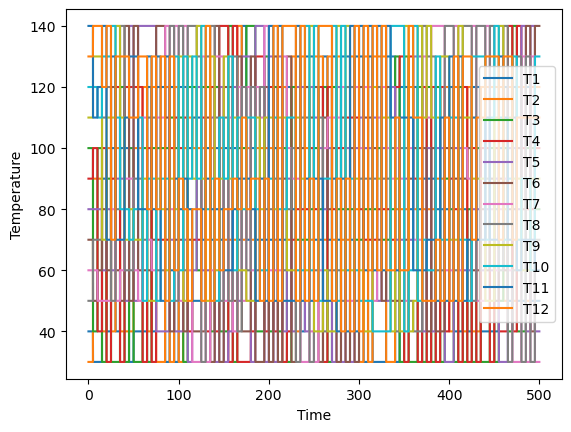

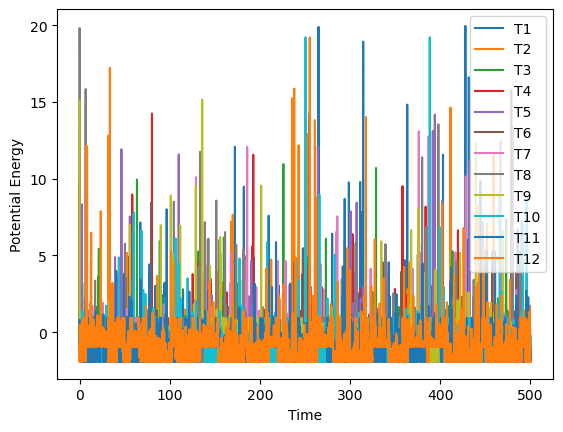

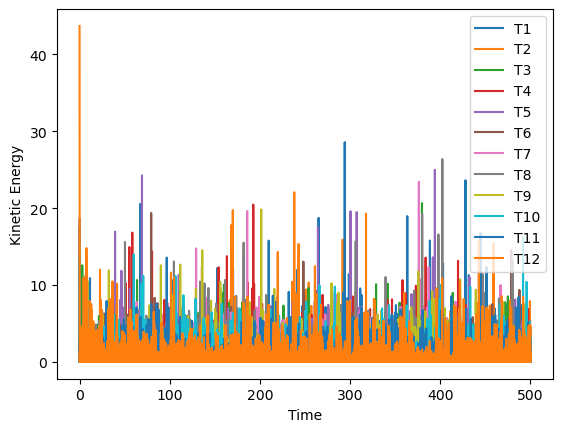

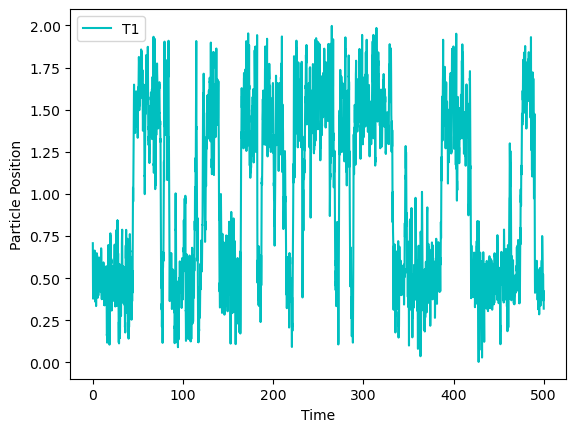

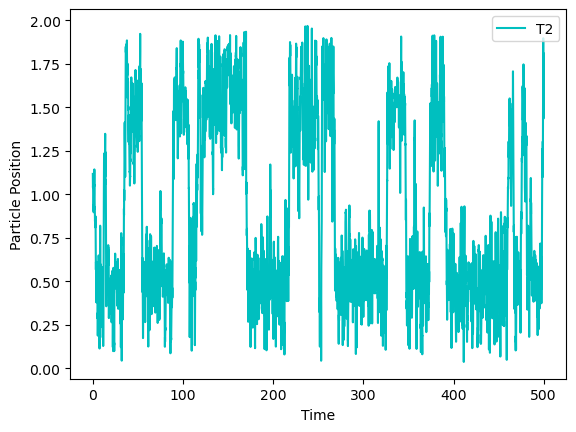

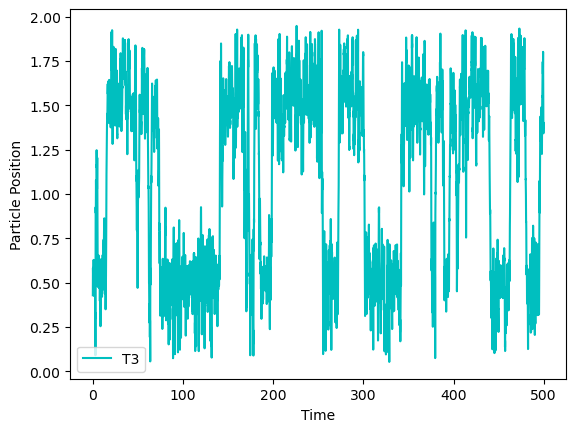

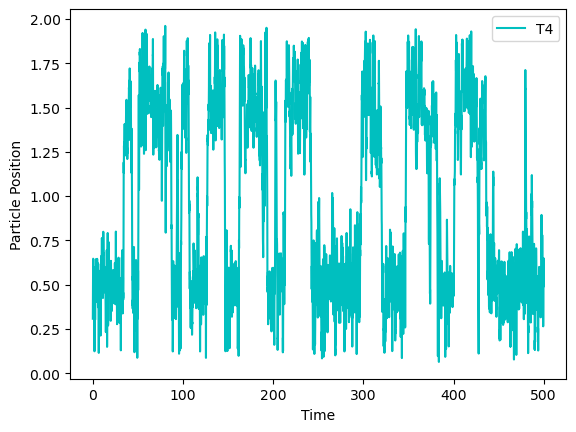

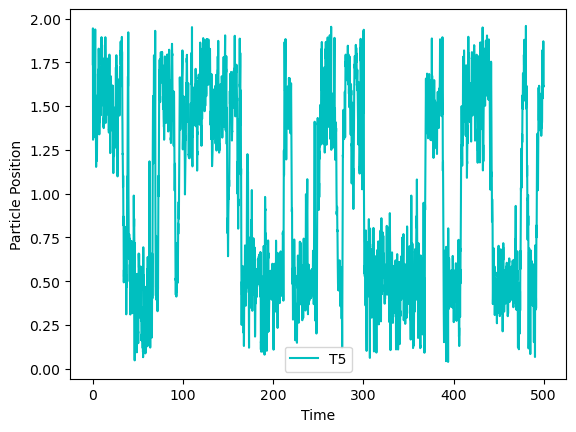

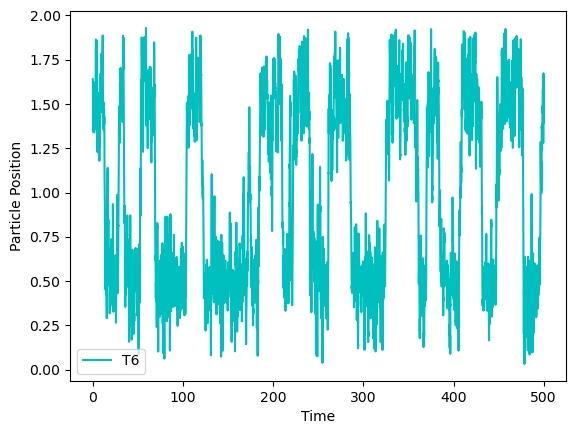

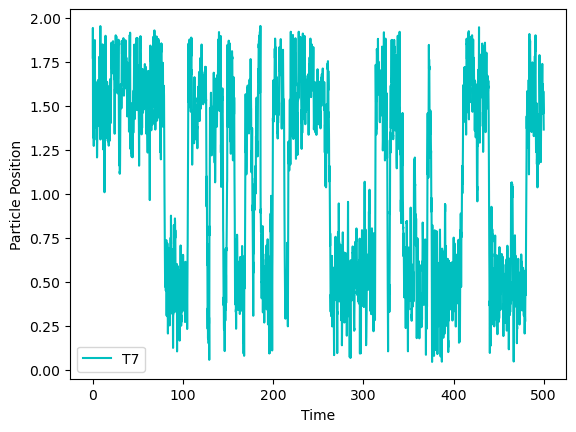

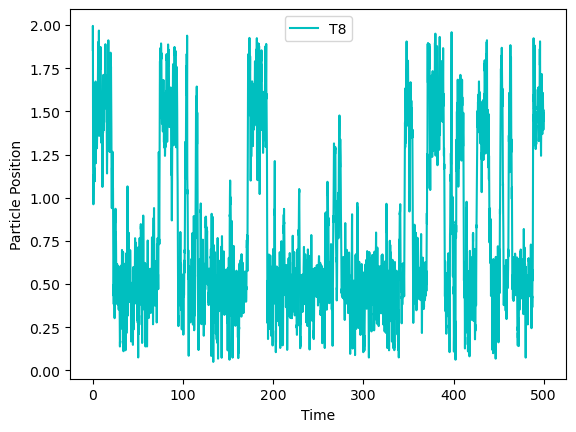

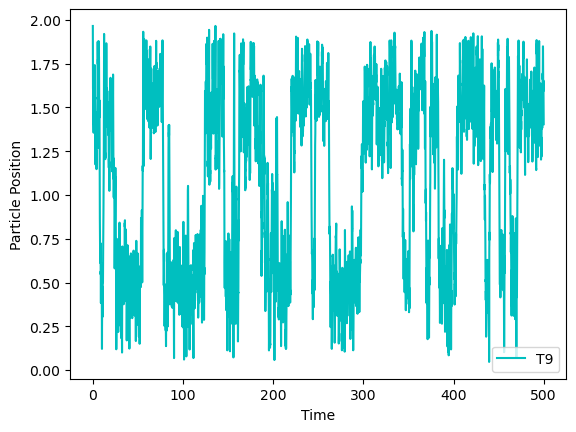

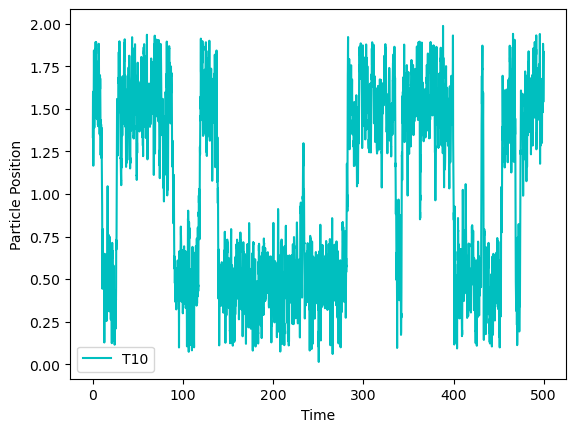

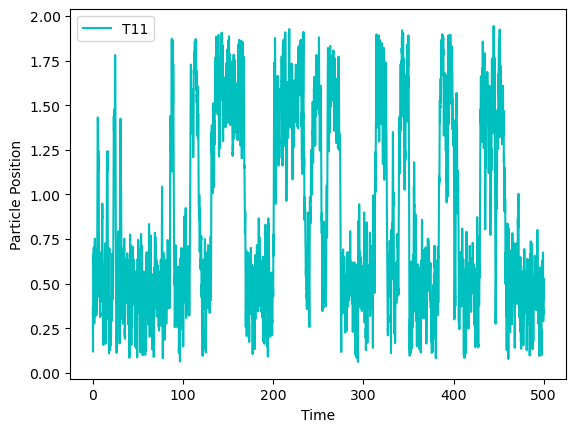

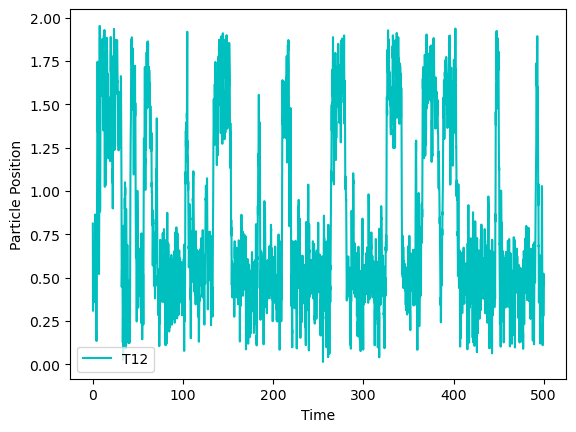

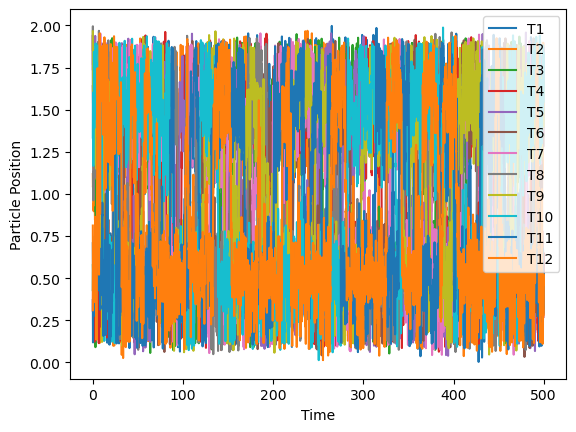

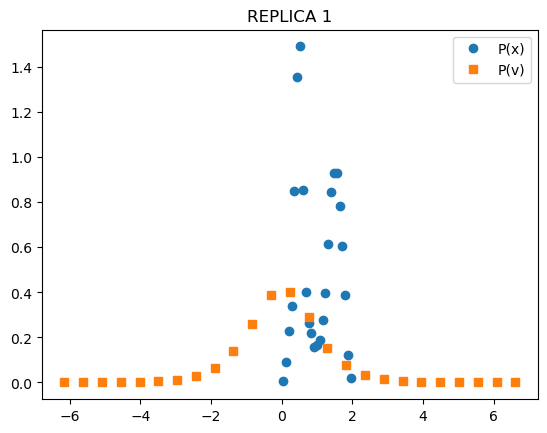

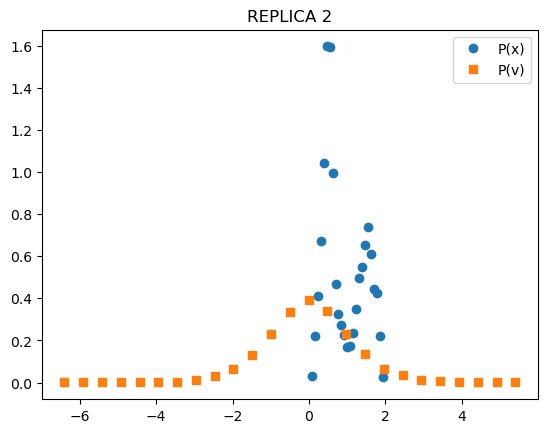

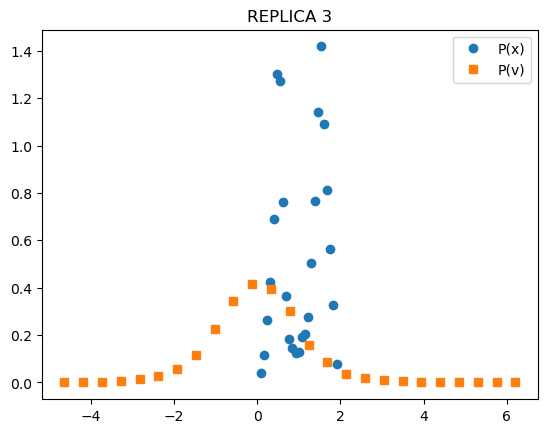

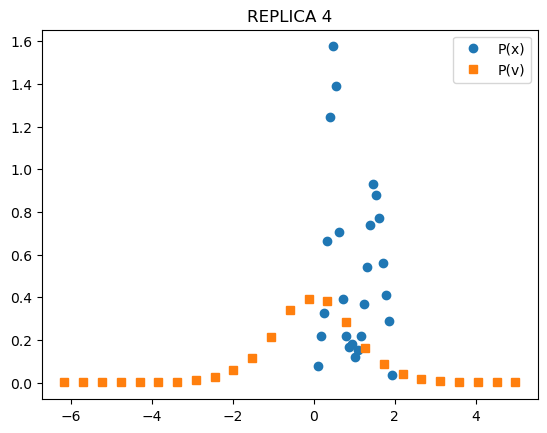

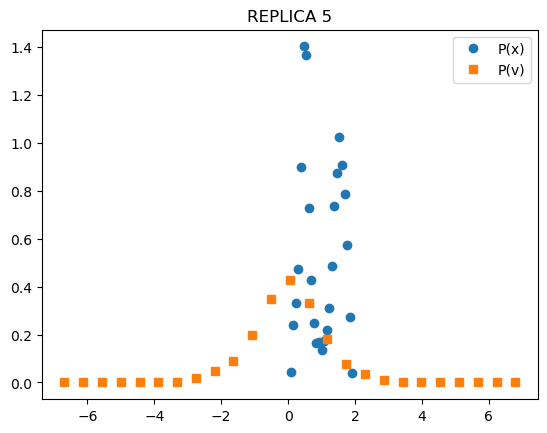

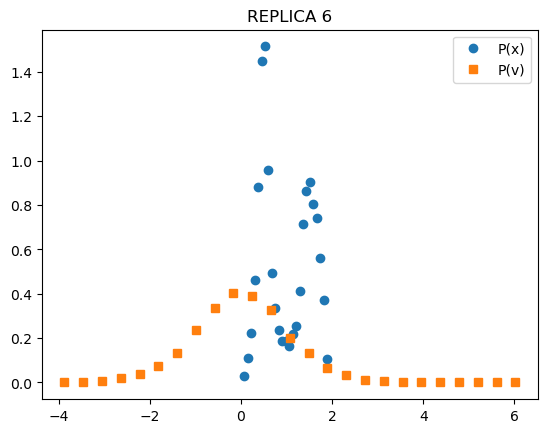

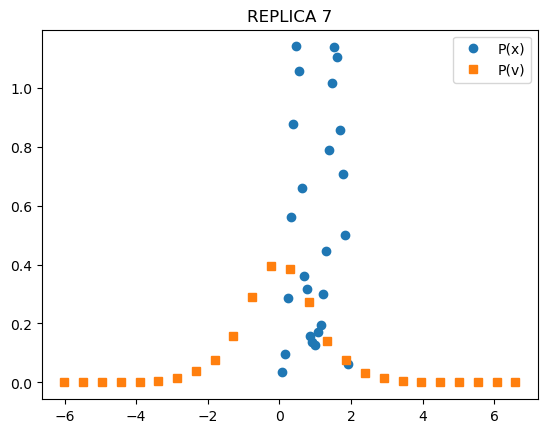

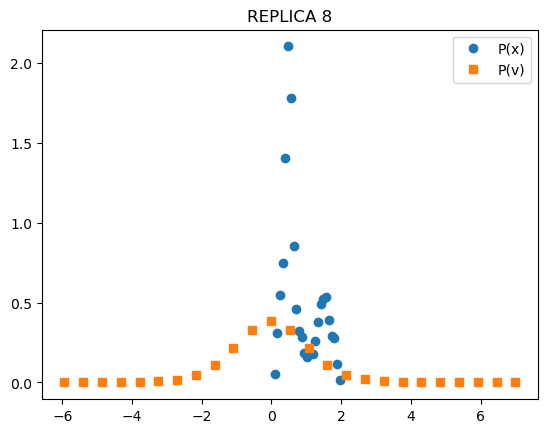

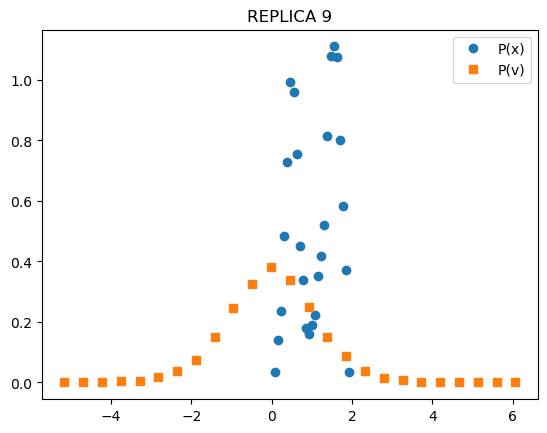

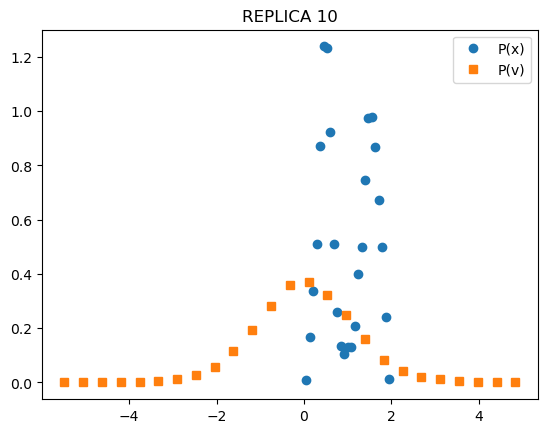

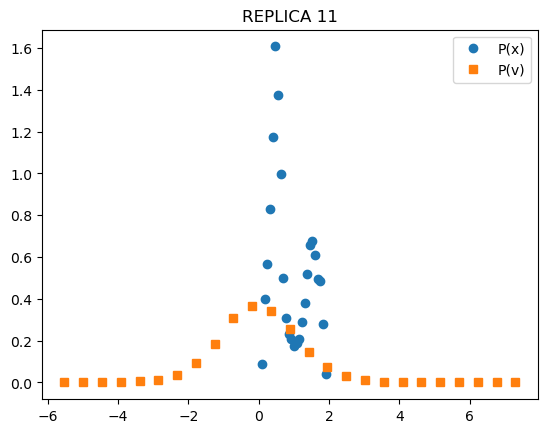

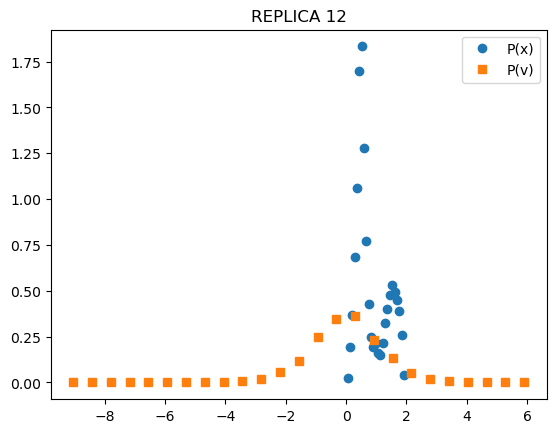

In [1580]:
MC_PT(30, 12, 0.05, 10000, 100, 100, 0.3, 1)

7 Replicas, With Swapping

T1: Kinetic Energy: 9.477, Potential Energy: 0.738, Total Energy: 10.215, Temperature: 30.000, Position: 1.883
T2: Kinetic Energy: 1.445, Potential Energy: 0.162, Total Energy: 1.607, Temperature: 50.000, Position: 0.771
T3: Kinetic Energy: 12.784, Potential Energy: 0.775, Total Energy: 13.559, Temperature: 40.000, Position: 1.085
T4: Kinetic Energy: 1.874, Potential Energy: 0.853, Total Energy: 2.727, Temperature: 70.000, Position: 1.056
T5: Kinetic Energy: 0.546, Potential Energy: 17.817, Total Energy: 18.363, Temperature: 60.000, Position: 1.978
T6: Kinetic Energy: 13.133, Potential Energy: -1.774, Total Energy: 11.359, Temperature: 90.000, Position: 0.552
T7: Kinetic Energy: 25.500, Potential Energy: 0.440, Total Energy: 25.940, Temperature: 80.000, Position: 1.167
Swap Acceptance Ratio (Pair 1): 0.000
Swap Acceptance Ratio (Pair 2): 0.333
Swap Acceptance Ratio (Pair 3): 0.000
Swap Acceptance Ratio (Pair 4): 0.333
Swap Acceptance Ratio (Pair 5): 0.000
Swap Acceptance Ratio (Pair 6)

T1: Kinetic Energy: 0.160, Potential Energy: -0.390, Total Energy: -0.230, Temperature: 40.000, Position: 0.229
T2: Kinetic Energy: 0.175, Potential Energy: -0.453, Total Energy: -0.278, Temperature: 50.000, Position: 1.766
T3: Kinetic Energy: 0.003, Potential Energy: -0.803, Total Energy: -0.800, Temperature: 70.000, Position: 1.636
T4: Kinetic Energy: 0.027, Potential Energy: -1.182, Total Energy: -1.155, Temperature: 90.000, Position: 0.347
T5: Kinetic Energy: 0.036, Potential Energy: -0.757, Total Energy: -0.721, Temperature: 80.000, Position: 1.655
T6: Kinetic Energy: 0.090, Potential Energy: 0.273, Total Energy: 0.364, Temperature: 30.000, Position: 1.200
T7: Kinetic Energy: 0.148, Potential Energy: -0.811, Total Energy: -0.662, Temperature: 60.000, Position: 1.633
Swap Acceptance Ratio (Pair 1): 0.154
Swap Acceptance Ratio (Pair 2): 0.128
Swap Acceptance Ratio (Pair 3): 0.231
Swap Acceptance Ratio (Pair 4): 0.128
Swap Acceptance Ratio (Pair 5): 0.205
Swap Acceptance Ratio (Pair 

T1: Kinetic Energy: 0.400, Potential Energy: -1.437, Total Energy: -1.037, Temperature: 40.000, Position: 0.380
T2: Kinetic Energy: 0.417, Potential Energy: -0.925, Total Energy: -0.509, Temperature: 30.000, Position: 1.486
T3: Kinetic Energy: 0.555, Potential Energy: -1.929, Total Energy: -1.374, Temperature: 80.000, Position: 0.508
T4: Kinetic Energy: 4.477, Potential Energy: -1.795, Total Energy: 2.682, Temperature: 50.000, Position: 0.436
T5: Kinetic Energy: 0.022, Potential Energy: -0.281, Total Energy: -0.258, Temperature: 60.000, Position: 0.203
T6: Kinetic Energy: 0.317, Potential Energy: -1.400, Total Energy: -1.083, Temperature: 70.000, Position: 0.375
T7: Kinetic Energy: 0.006, Potential Energy: -1.327, Total Energy: -1.321, Temperature: 90.000, Position: 0.612
Swap Acceptance Ratio (Pair 1): 0.227
Swap Acceptance Ratio (Pair 2): 0.147
Swap Acceptance Ratio (Pair 3): 0.240
Swap Acceptance Ratio (Pair 4): 0.160
Swap Acceptance Ratio (Pair 5): 0.200
Swap Acceptance Ratio (Pair

T1: Kinetic Energy: 0.003, Potential Energy: -0.214, Total Energy: -0.210, Temperature: 80.000, Position: 1.289
T2: Kinetic Energy: 0.954, Potential Energy: -0.937, Total Energy: 0.018, Temperature: 60.000, Position: 1.499
T3: Kinetic Energy: 1.160, Potential Energy: -0.325, Total Energy: 0.834, Temperature: 40.000, Position: 1.814
T4: Kinetic Energy: 0.328, Potential Energy: -1.309, Total Energy: -0.981, Temperature: 50.000, Position: 0.363
T5: Kinetic Energy: 0.015, Potential Energy: -1.490, Total Energy: -1.475, Temperature: 90.000, Position: 0.387
T6: Kinetic Energy: 0.468, Potential Energy: -1.927, Total Energy: -1.459, Temperature: 70.000, Position: 0.510
T7: Kinetic Energy: 0.738, Potential Energy: -1.564, Total Energy: -0.826, Temperature: 30.000, Position: 0.584
Swap Acceptance Ratio (Pair 1): 0.197
Swap Acceptance Ratio (Pair 2): 0.154
Swap Acceptance Ratio (Pair 3): 0.222
Swap Acceptance Ratio (Pair 4): 0.171
Swap Acceptance Ratio (Pair 5): 0.299
Swap Acceptance Ratio (Pair 

T1: Kinetic Energy: 1.199, Potential Energy: -0.566, Total Energy: 0.633, Temperature: 50.000, Position: 1.725
T2: Kinetic Energy: 0.779, Potential Energy: -1.829, Total Energy: -1.050, Temperature: 90.000, Position: 0.541
T3: Kinetic Energy: 0.654, Potential Energy: -0.325, Total Energy: 0.329, Temperature: 30.000, Position: 1.814
T4: Kinetic Energy: 0.003, Potential Energy: -0.893, Total Energy: -0.890, Temperature: 70.000, Position: 1.590
T5: Kinetic Energy: 0.712, Potential Energy: -1.930, Total Energy: -1.218, Temperature: 80.000, Position: 0.478
T6: Kinetic Energy: 0.000, Potential Energy: -0.475, Total Energy: -0.475, Temperature: 40.000, Position: 1.758
T7: Kinetic Energy: 0.395, Potential Energy: -0.943, Total Energy: -0.548, Temperature: 60.000, Position: 1.510
Swap Acceptance Ratio (Pair 1): 0.229
Swap Acceptance Ratio (Pair 2): 0.170
Swap Acceptance Ratio (Pair 3): 0.216
Swap Acceptance Ratio (Pair 4): 0.150
Swap Acceptance Ratio (Pair 5): 0.288
Swap Acceptance Ratio (Pair 

T1: Kinetic Energy: 0.015, Potential Energy: -1.900, Total Energy: -1.885, Temperature: 60.000, Position: 0.463
T2: Kinetic Energy: 0.036, Potential Energy: -0.916, Total Energy: -0.880, Temperature: 50.000, Position: 1.478
T3: Kinetic Energy: 1.611, Potential Energy: 0.892, Total Energy: 2.503, Temperature: 40.000, Position: 0.933
T4: Kinetic Energy: 0.642, Potential Energy: -0.461, Total Energy: 0.181, Temperature: 90.000, Position: 1.763
T5: Kinetic Energy: 0.469, Potential Energy: 0.217, Total Energy: 0.686, Temperature: 30.000, Position: 0.778
T6: Kinetic Energy: 0.154, Potential Energy: -0.914, Total Energy: -0.760, Temperature: 80.000, Position: 1.575
T7: Kinetic Energy: 0.055, Potential Energy: -0.642, Total Energy: -0.588, Temperature: 70.000, Position: 1.378
Swap Acceptance Ratio (Pair 1): 0.226
Swap Acceptance Ratio (Pair 2): 0.199
Swap Acceptance Ratio (Pair 3): 0.253
Swap Acceptance Ratio (Pair 4): 0.172
Swap Acceptance Ratio (Pair 5): 0.258
Swap Acceptance Ratio (Pair 6):

T1: Kinetic Energy: 0.064, Potential Energy: -1.786, Total Energy: -1.723, Temperature: 90.000, Position: 0.434
T2: Kinetic Energy: 0.044, Potential Energy: -0.799, Total Energy: -0.755, Temperature: 50.000, Position: 1.423
T3: Kinetic Energy: 0.186, Potential Energy: -1.699, Total Energy: -1.513, Temperature: 60.000, Position: 0.565
T4: Kinetic Energy: 0.070, Potential Energy: -0.904, Total Energy: -0.834, Temperature: 40.000, Position: 1.470
T5: Kinetic Energy: 0.450, Potential Energy: -0.773, Total Energy: -0.323, Temperature: 30.000, Position: 1.649
T6: Kinetic Energy: 0.030, Potential Energy: -1.830, Total Energy: -1.801, Temperature: 80.000, Position: 0.443
T7: Kinetic Energy: 1.011, Potential Energy: -0.765, Total Energy: 0.246, Temperature: 70.000, Position: 1.652
Swap Acceptance Ratio (Pair 1): 0.236
Swap Acceptance Ratio (Pair 2): 0.191
Swap Acceptance Ratio (Pair 3): 0.236
Swap Acceptance Ratio (Pair 4): 0.169
Swap Acceptance Ratio (Pair 5): 0.267
Swap Acceptance Ratio (Pair

T1: Kinetic Energy: 0.595, Potential Energy: -0.338, Total Energy: 0.257, Temperature: 50.000, Position: 1.312
T2: Kinetic Energy: 1.192, Potential Energy: -1.076, Total Energy: 0.116, Temperature: 80.000, Position: 0.638
T3: Kinetic Energy: 1.663, Potential Energy: -0.880, Total Energy: 0.783, Temperature: 30.000, Position: 1.598
T4: Kinetic Energy: 0.936, Potential Energy: -0.383, Total Energy: 0.554, Temperature: 40.000, Position: 1.793
T5: Kinetic Energy: 0.053, Potential Energy: -0.814, Total Energy: -0.760, Temperature: 70.000, Position: 1.428
T6: Kinetic Energy: 0.019, Potential Energy: -1.911, Total Energy: -1.893, Temperature: 90.000, Position: 0.517
T7: Kinetic Energy: 0.245, Potential Energy: -0.670, Total Energy: -0.425, Temperature: 60.000, Position: 1.385
Swap Acceptance Ratio (Pair 1): 0.242
Swap Acceptance Ratio (Pair 2): 0.197
Swap Acceptance Ratio (Pair 3): 0.254
Swap Acceptance Ratio (Pair 4): 0.197
Swap Acceptance Ratio (Pair 5): 0.295
Swap Acceptance Ratio (Pair 6)

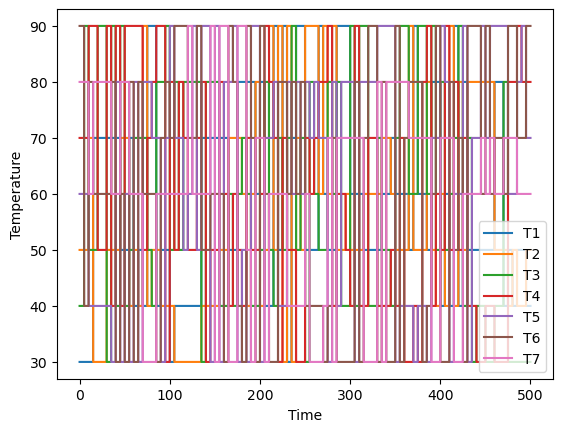

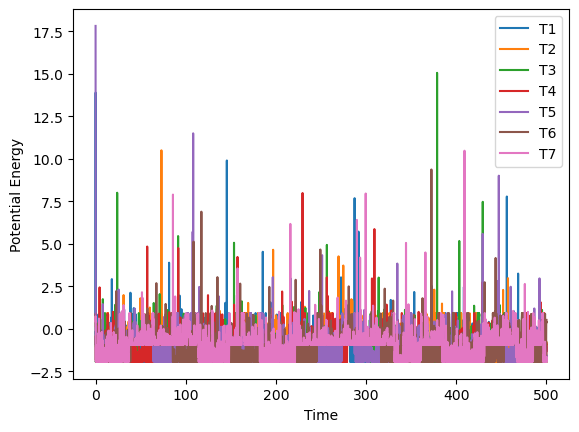

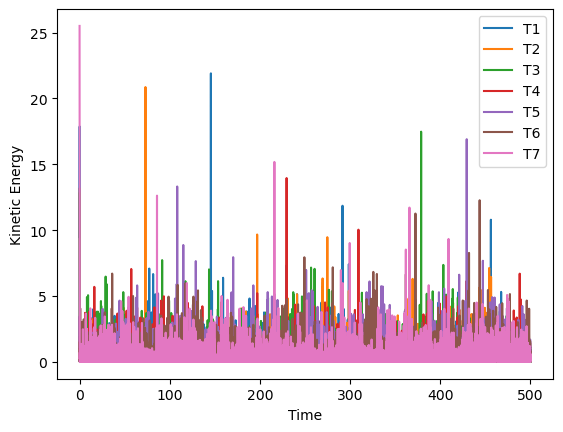

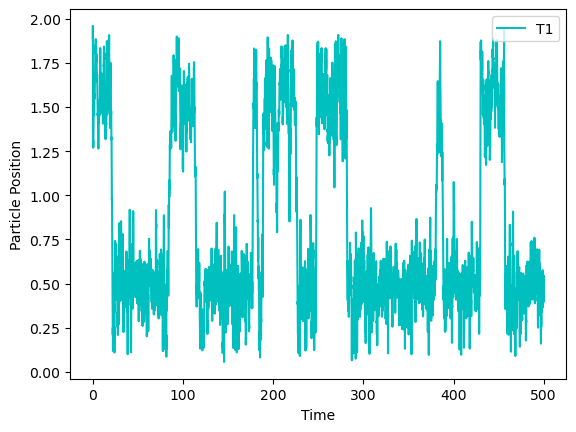

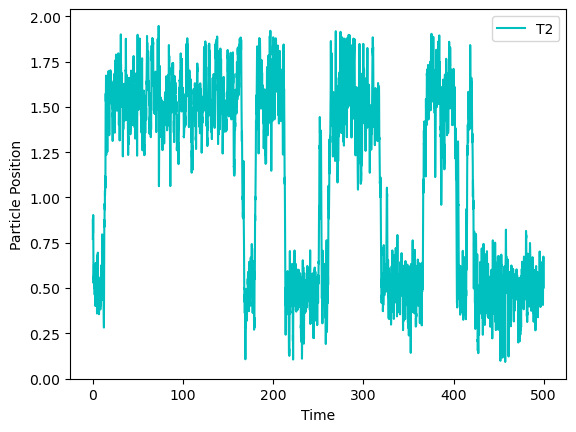

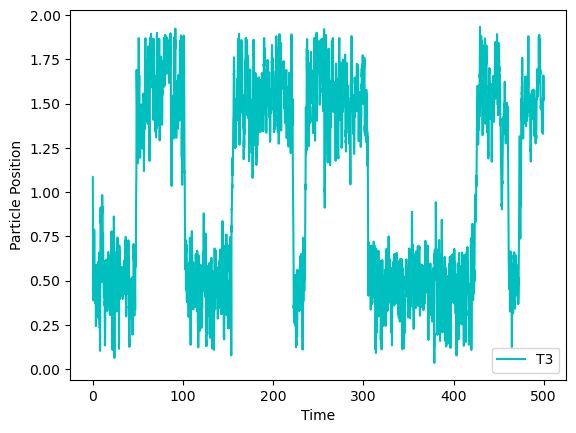

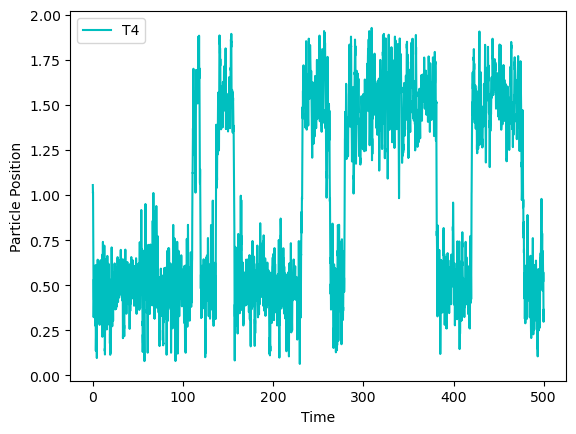

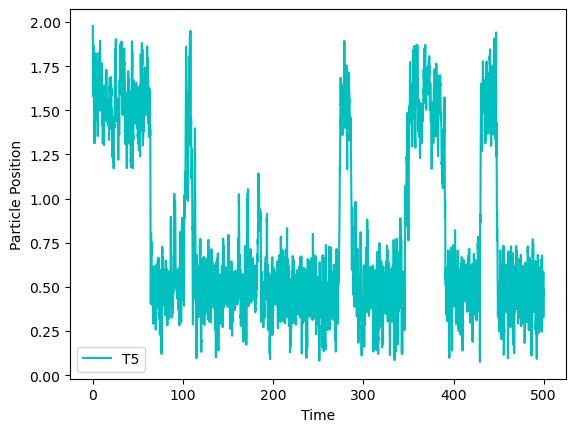

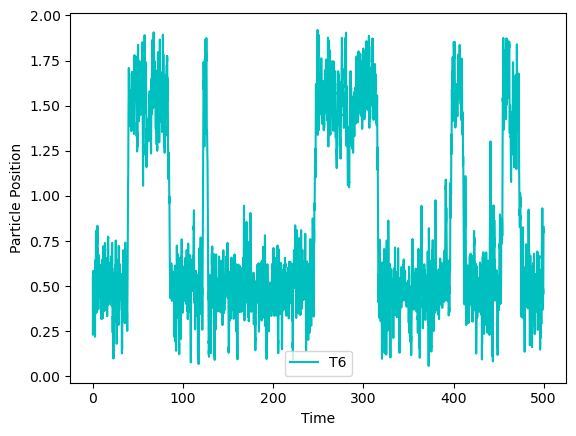

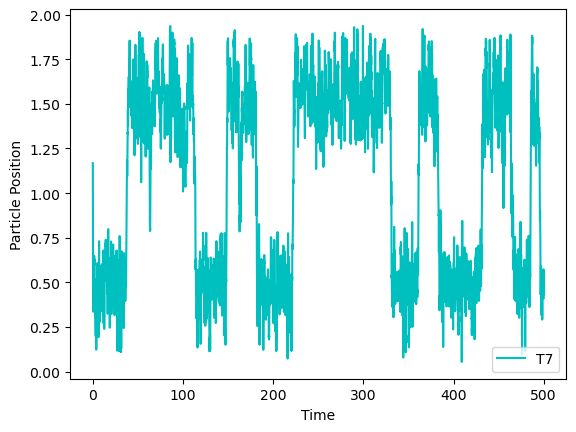

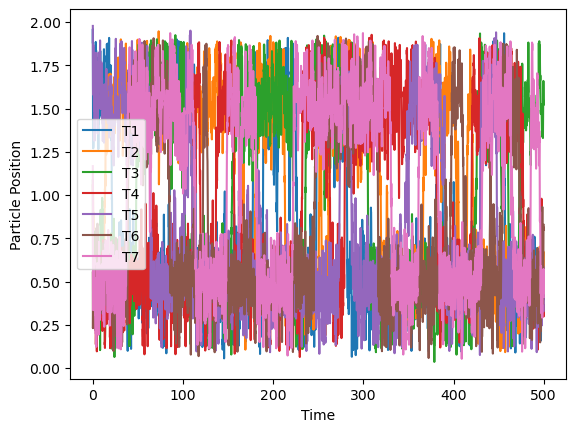

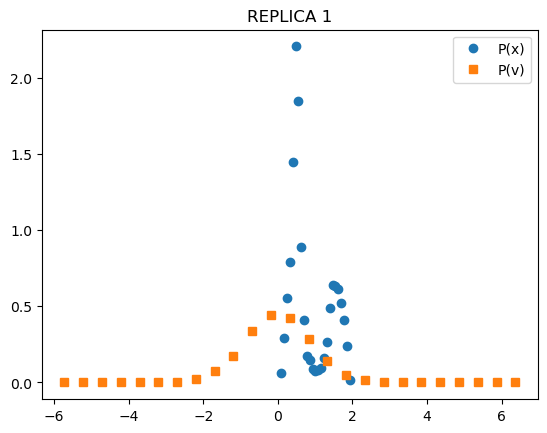

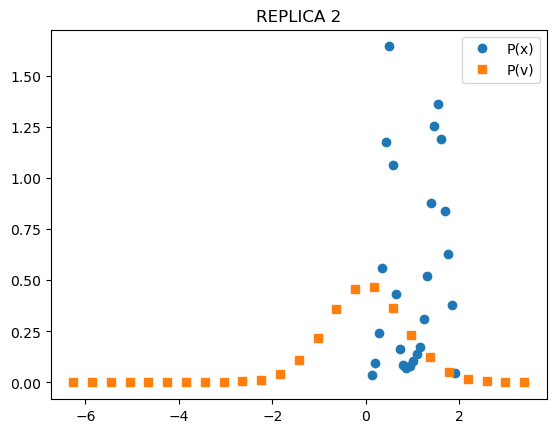

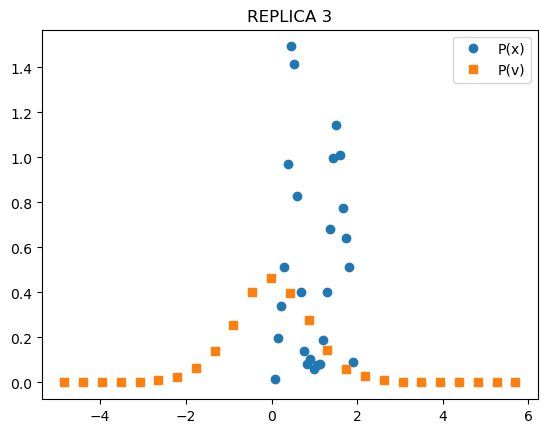

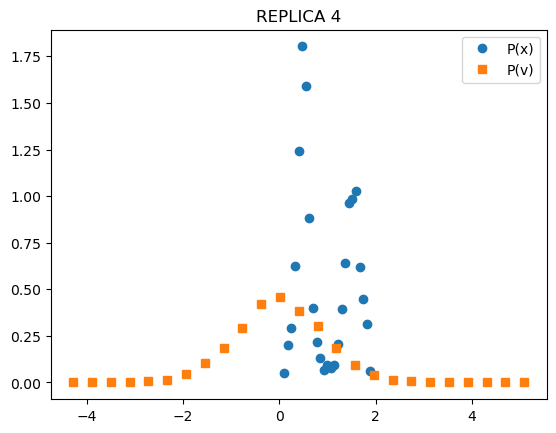

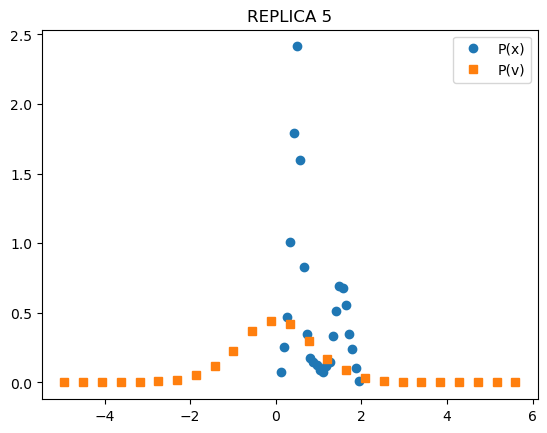

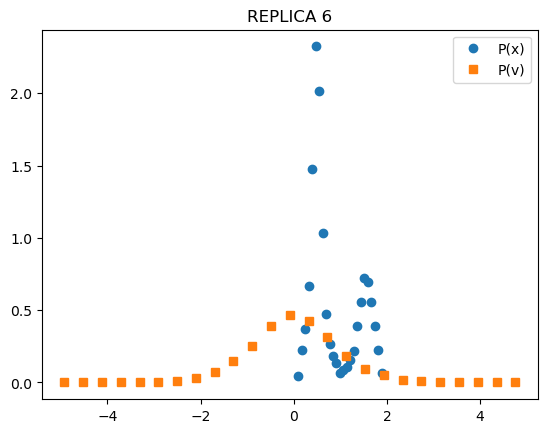

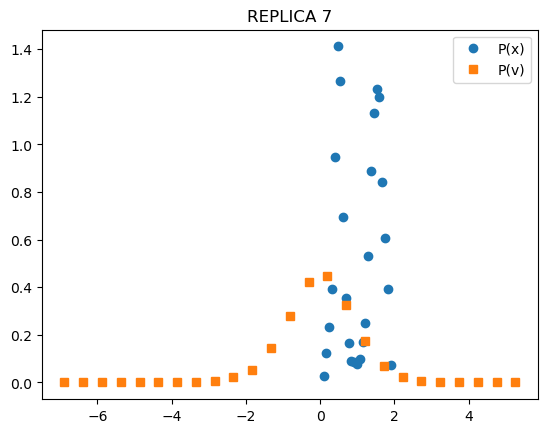

In [1584]:
MC_PT(30, 7, 0.05, 10000, 100, 100, 0.3, 1)